# Preamble

In [1]:
import tifffile as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap,LinearSegmentedColormap,Normalize
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib import rc
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('ytick', labelsize=28) 
plt.rc('xtick', labelsize=28)

import skimage as sk
from skimage.feature import canny
import skimage.io as skio

import math,os, json

import glob

import imageio.v2 as imageio

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

import scipy as sp
import scipy.stats as stats
from scipy.stats import ks_2samp, kruskal,ttest_ind,spearmanr,pearsonr
from scipy.signal import medfilt2d

from PIL import Image

import pandas as pd
from pathlib import Path
import scikit_posthocs as skp


import seaborn as sns

from statannotations.Annotator import Annotator

import shutil



In [2]:
def rgb_to_grayscale(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

In [3]:
tool = "Tool"
tool_list = ["StarSearch","SpyDen"]
compartments = ["soma","neurites"]
isoforms = ["E6","E7"]
stat_test = "Kruskal"

In [4]:
def cleandata(data):
    temp_data = data.iloc[2:-3,1::3]
    temp_data = temp_data.rename(columns={"neurite":"neurite-E6","Unnamed: 4":"neurite-E7","soma":"soma-E6","Unnamed: 10":"soma-E7"})
    temp_data["Neuron"] = data.iloc[2:-3,0]
    final_data = pd.DataFrame()
    ind = 0
    for i in range(temp_data.shape[0]):
        n = compartments[1]
        iso = isoforms[0]
        neuron = i+1
        count = temp_data.iloc[i]["neurite-E6"]
        to_add = {"compartment":n,"isoform":iso,"Num":count,"Neuron":neuron}

        temp = pd.DataFrame(to_add,index=[0])
        final_data = pd.concat((final_data,temp), ignore_index = True)
        
        n = compartments[1]
        iso = isoforms[1]
        count = temp_data.iloc[i]["neurite-E7"]
        to_add = {"compartment":n,"isoform":iso,"Num":count,"Neuron":neuron}

        temp = pd.DataFrame(to_add,index=[0])
        final_data = pd.concat((final_data,temp), ignore_index = True)
        
        n = compartments[0]
        iso = isoforms[0]
        count = temp_data.iloc[i]["soma-E6"]
        to_add = {"compartment":n,"isoform":iso,"Num":count,"Neuron":neuron}
        ind += 1
        temp = pd.DataFrame(to_add,index=[0])
        final_data = pd.concat((final_data,temp), ignore_index = True)
        
        n = compartments[0]
        iso = isoforms[1]
        count = temp_data.iloc[i]["soma-E7"]
        to_add = {"compartment":n,"isoform":iso,"Num":count,"Neuron":neuron}
        ind += 1
        temp = pd.DataFrame(to_add,index=[0])
        final_data = pd.concat((final_data,temp), ignore_index = True)
    return final_data


In [5]:
def AnnotateText(ax,x1,x2,y,h,txt,color,ha='center',va='bottom',fsize=24):

        if not txt == '':
            fac = np.abs(x2-x1)*0.04
            trans = ax.get_xaxis_transform()
            plt.hlines(xmin=x1,xmax=x2, y = y+fac, lw=1.5, color=color)#, transform=trans)
            plt.text((x1+ x2)*0.5,y+h+fac,txt, ha=ha, va=va, color=color,fontsize=fsize)#,transform=trans )
            
def SwarmBoxCombo(dp,x,y,fbase,xlabel,ylabel,title,frac=True,pairs = [[1,3],[2,4]]):
    for kk,compa in enumerate(compartments):

        fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
        xfsize = 30
        ax.tick_params(axis='both', which='major', labelsize=xfsize)
        ax.grid(False)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        comp_to_analyse = compa
        order = isoforms
        hue = tool
        hue_order = tool_list
        color_pal = ['b','g']
        data_to_plot = dp[dp["compartment"]==comp_to_analyse]
        hue_plot_params = {
                    'data': data_to_plot,
                    'x': x,
                    'y': y,
                    "order": order,
                    "hue": hue,
                    "hue_order": hue_order,
                    "palette": color_pal,

                }


        sns.swarmplot(**hue_plot_params,
                      dodge=True,
                      zorder=1,
                      size = 8,
                      ax=ax)

        sns.boxplot(**hue_plot_params,
                    fill=False,
                    showmeans=True ,
                    meanprops={"marker": "^",
                       "markeredgecolor": "k",
                       "markerfacecolor":"k",
                       "markersize": "10"},
                    width=0.8,
                    gap=.8,
                    ax=ax)
        if frac:
            comp_data = np.array(data_to_plot.groupby(["isoform","Tool"]).fractions.apply(list).tolist())#.to_numpy()
        else:
            comp_data = np.array(data_to_plot.groupby(["isoform","Tool"]).Num.apply(list).tolist())#.to_numpy()
        x_pos1 = np.array([-0.2,0.2])
        alph =0.1
        x_pos2 = np.array([1-0.2,1+0.2])
        x_poss = [-0.2,0.2,1-0.2,1+0.2]

        for i in range(comp_data.shape[1]): 
            y_plot1 = np.array([comp_data[1,i],comp_data[0,i]])
            y_plot2 = np.array([comp_data[3,i],comp_data[2,i]])

            ax.plot(x_pos1,y_plot1,color='k',alpha=alph)
            ax.plot(x_pos2,y_plot2,color='k',alpha=alph)

        p_values = skp.posthoc_dunn(comp_data,p_adjust = 'bonferroni')

        ymax = comp_data.max()
        for pdx,pair in enumerate(pairs):
            txt = ''

            if p_values[pair[0]][pair[1]] > 0.05:
                txt= "ns"
            else:
                if p_values[pair[0]][pair[1]] <= 0.05:
                    txt += '*'
                if p_values[pair[0]][pair[1]] <= 0.01:
                    txt += '*'
                if p_values[pair[0]][pair[1]] <= 0.001:
                    txt += '*'

            AnnotateText(ax,x_poss[pair[0]-1],x_poss[pair[1]-1],ymax+0.1*pdx,0.01,txt,'k')
        ax.set_xlabel(xlabel,fontsize=xfsize)
        ax.set_ylabel(ylabel,fontsize=xfsize)
        # ax.set_title(title+" {}".format(comp_to_analyse),fontsize=xfsize)
        plt.legend([],[],frameon=False)



In [6]:
def SwarmBoxComboSoma(dp,x,y,fbase,xlabel,ylabel,title,frac=True,pairs = [[1,3],[2,4]]):
    fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
    xfsize = 30
    ax.tick_params(axis='both', which='major', labelsize=xfsize)
    ax.grid(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    order = compartments
    hue = tool
    hue_order = tool_list
    color_pal = ['r','g']
    data_to_plot = dp
    hue_plot_params = {
                'data': data_to_plot,
                'x': x,
                'y': y,
                "order": order,
                "hue": hue,
                "hue_order": hue_order,
                "palette": color_pal,

            }

    sns.swarmplot(**hue_plot_params,
                  dodge=True,
                  zorder=1,
                  size = 8,
                  native_scale=True,
                  ax=ax)
    sns.boxplot(**hue_plot_params,
                fill=False,
                showmeans=True ,
                meanprops={"marker": "^",
                   "markeredgecolor": "k",
                   "markerfacecolor":"k",
                   "markersize": "10"},
                width=0.8,
                showfliers=False,
                gap=.8,
                ax=ax)
    if frac:
        comp_data = np.array(data_to_plot.groupby(["compartment","Tool"]).fractions.apply(list).tolist())#.to_numpy()
        ax.set_ylim([0.2,1])
    else:
        comp_data = np.array(data_to_plot.groupby(["compartment","Tool"]).Num.apply(list).tolist())#.to_numpy()
    x_pos1 = np.array([-0.2,0.2])
    alph =0.1
    x_pos2 = np.array([1-0.2,1+0.2])
    x_poss = [-0.2,0.2,1-0.2,1+0.2]

    for i in range(comp_data.shape[1]): 
        y_plot1 = np.array([comp_data[2,i],comp_data[3,i]])
        y_plot2 = np.array([comp_data[0,i],comp_data[1,i]])
        ax.plot(x_pos1,y_plot1,color='k',alpha=alph)
        ax.plot(x_pos2,y_plot2,color='k',alpha=alph)
    # # for p in pairs
    p_values = skp.posthoc_dunn(comp_data,p_adjust = 'bonferroni')
    ymax = comp_data.max()
    for pdx,pair in enumerate(pairs):
        txt = ''
        if p_values[pair[0]][pair[1]] > 0.05:
            txt= "ns"
        else:
            if p_values[pair[0]][pair[1]] <= 0.05:
                txt += '*'
            if p_values[pair[0]][pair[1]] <= 0.01:
                txt += '*'
            if p_values[pair[0]][pair[1]] <= 0.001:
                txt += '*'
        AnnotateText(ax,x_poss[pair[0]-1],x_poss[pair[1]-1],ymax+0.1*pdx,0.01,txt,'k')
    ax.set_xlabel(xlabel,fontsize=xfsize)
    ax.set_ylabel(ylabel,fontsize=xfsize)

    plt.legend([],[],frameon=False)

In [7]:
def merge_data(full_pd,data,compartment,isoform,c_id):
    data["compartment"] = compartment
    data["isoform"] = isoform
    data["Neuron"] = c_id

    return full_pd

In [8]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
}

def iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


In [9]:
sDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/'

# Fig 3

## Fig 3a

In [10]:
img = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/Figure3/HelmEgDend.png")
mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Manual/15.png')
mm = mm[:, :, 0]
am = ((mm >= 250)*1).astype(np.float64)
am[am==0] = math.nan
mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool/15.png")
am2 = ((mm >= 250)*1).astype(np.float64)
am2[am2==0] = math.nan

mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool better/15.png")
am3 = ((mm >= 250)*1).astype(np.float64)
am3[am3==0] = math.nan

([], [])

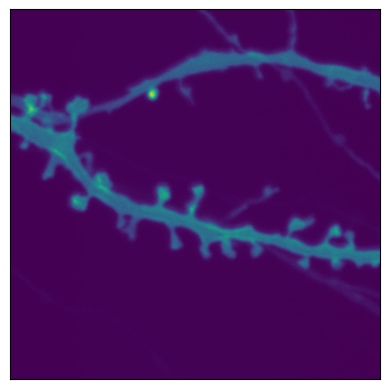

In [11]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])

([], [])

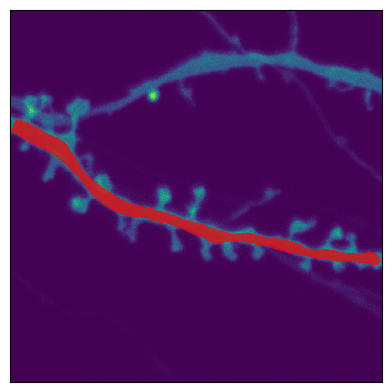

In [12]:
plt.matshow(img)
cmap = mcolors.ListedColormap(['red'])
plt.imshow(am,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])


([], [])

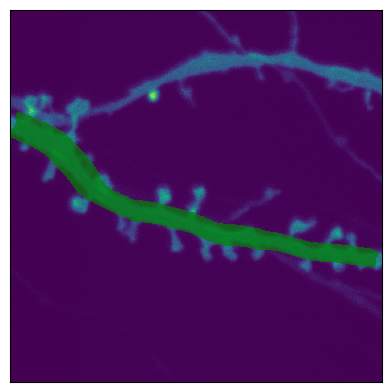

In [13]:
cmap = mcolors.ListedColormap(['green'])
plt.matshow(img)
plt.imshow(am2,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])

([], [])

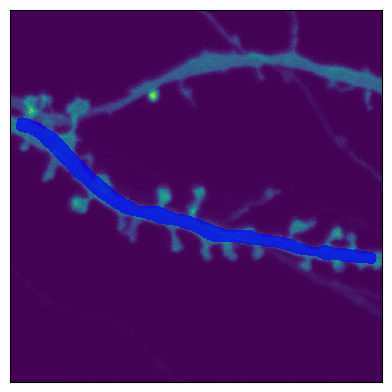

In [14]:
cmap = mcolors.ListedColormap(['blue'])
plt.matshow(img)
plt.imshow(am3,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])

## Fig 3b

In [15]:
img = tf.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/Figure3/GodaEgDend.lsm").max(axis=0)
mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda/Manual/1.png')
am = ((mm >= 250)*1).astype(np.float64)
am[am==0] = math.nan
mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda/Tool1/1.png')
am2 = ((mm >= 250)*1).astype(np.float64)
am2[am2==0] = math.nan

mm = mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda/Tool2/1.png')
am3 = ((mm >= 250)*1).astype(np.float64)
am3[am3==0] = math.nan

([], [])

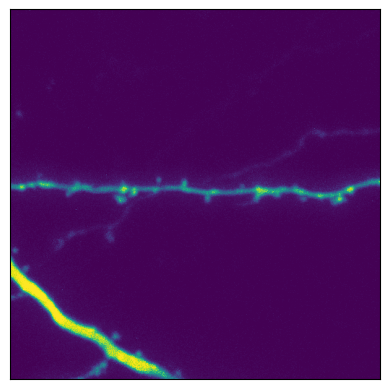

In [16]:
plt.imshow(img)
plt.xticks([])
plt.yticks([])

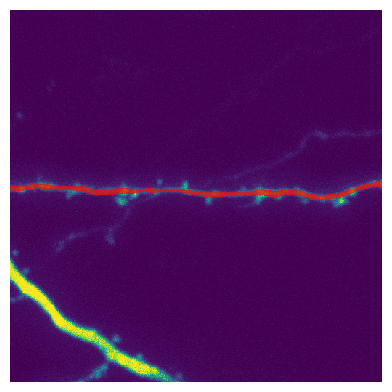

In [17]:
plt.matshow(img)
cmap = mcolors.ListedColormap(['red'])
plt.imshow(am[::2,::2],alpha=0.7,cmap=cmap)
plt.axis('off')
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/DendExampleG_MaskTrue.pdf',format='pdf',bbox_inches='tight')

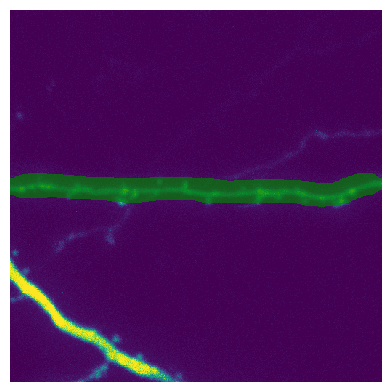

In [18]:
cmap = mcolors.ListedColormap(['green'])
plt.matshow(img)
plt.imshow(am2,alpha=0.7,cmap=cmap)
plt.axis('off')
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/DendExampleG_Mask1.pdf',format='pdf',bbox_inches='tight')

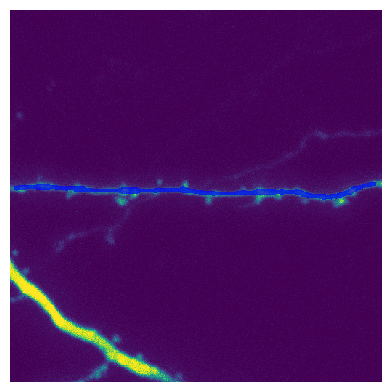

In [19]:
cmap = mcolors.ListedColormap(['blue'])
plt.matshow(img)
plt.imshow(am3,alpha=0.7,cmap=cmap)
plt.axis('off')
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/DendExampleG_Mask2.pdf',format='pdf',bbox_inches='tight')

## Fig 3c

In [20]:
img = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Raw/2.png")
img = rgb_to_grayscale(img)

mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Manual/2 dendrite.png')
am = ((mm >= 250)*1).astype(np.float64)
am[am==0] = math.nan

mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Tool/2/Dendrite/Mask_dend0.png")
am2 = ((mm >= 250)*1).astype(np.float64)
am2[am2==0] = math.nan

mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Tool better/2/Dendrite/Mask_dend0.png")
am3 = ((mm >= 250)*1).astype(np.float64)
am3[am3==0] = math.nan

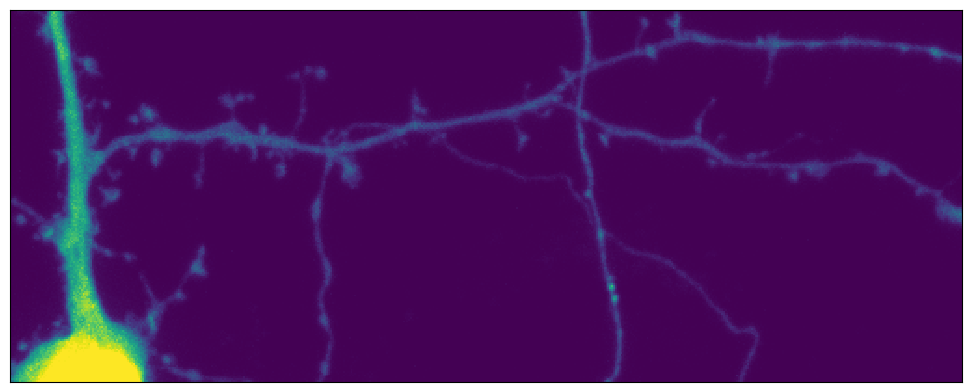

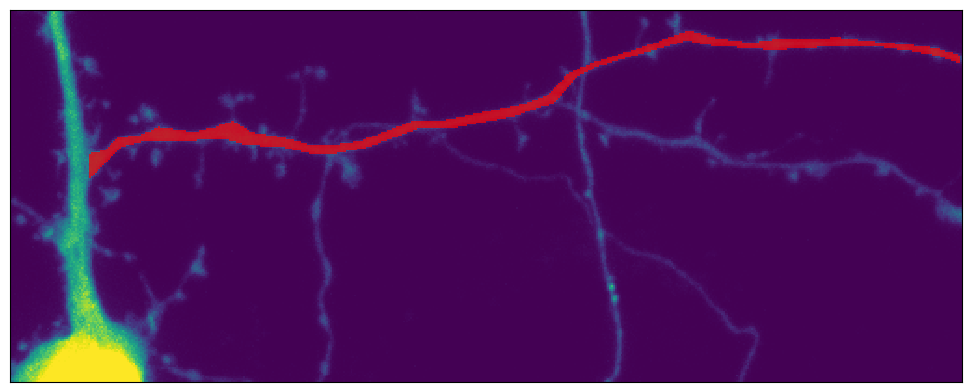

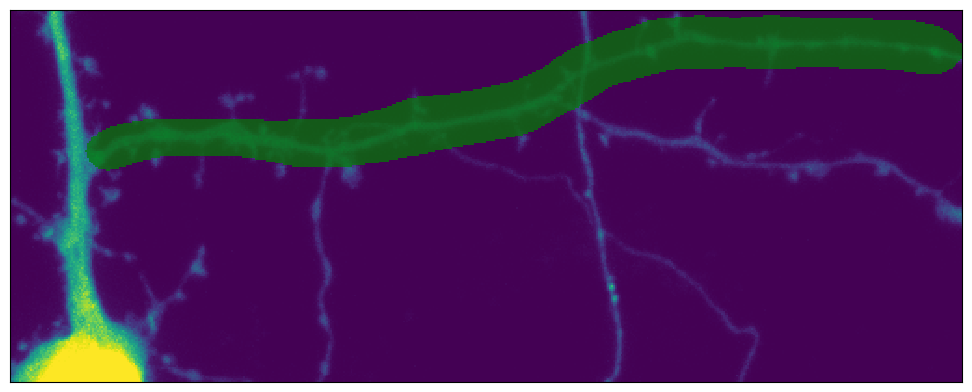

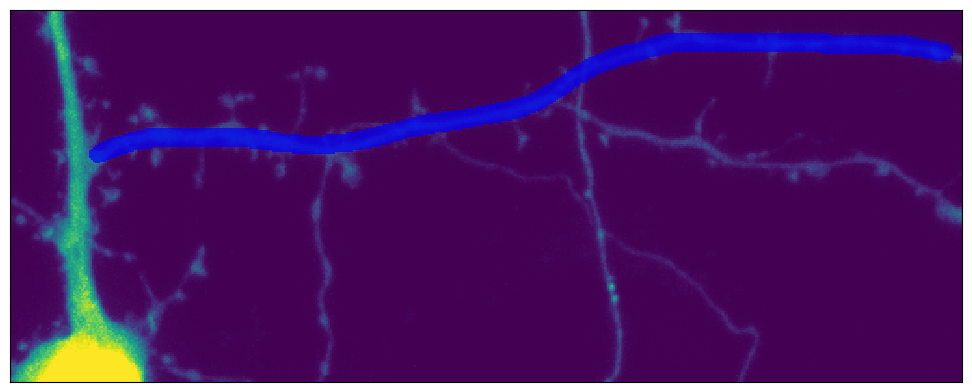

In [21]:
plt.matshow(img)
cmap = mcolors.ListedColormap(['red'])
plt.xticks([])
plt.yticks([])
plt.savefig(sDir+'DendExampleC_Raw.pdf',format='pdf',bbox_inches='tight')
plt.show()

plt.matshow(img)
cmap = mcolors.ListedColormap(['red'])
plt.imshow(am,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.savefig(sDir+'DendExampleC_Manual.pdf',format='pdf',bbox_inches='tight')
plt.show()

cmap = mcolors.ListedColormap(['green'])
plt.matshow(img)
plt.imshow(am2,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.savefig(sDir+'DendExampleC_Mask1.pdf',format='pdf',bbox_inches='tight')
plt.show()

cmap = mcolors.ListedColormap(['blue'])
plt.matshow(img)
plt.imshow(am3,alpha=0.7,cmap=cmap)
plt.xticks([])
plt.yticks([])
plt.savefig(sDir+'DendExampleC_Mask2.pdf',format='pdf',bbox_inches='tight')
plt.show()

In [22]:
mm = skio.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Manual/15.png')
mm = mm[:, :, 0]
am = ((mm >= 250)*1).astype(np.float64)
am[am==0] = math.nan
mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool/15.png")
am2 = ((mm >= 250)*1).astype(np.float64)
am2[am2==0] = math.nan

mm = skio.imread("/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool better/15.png")
am3 = ((mm >= 250)*1).astype(np.float64)
am3[am3==0] = math.nan

In [23]:
def bresenham_line(x0, y0, x1, y1):
    points = []
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    
    err = dx - dy
    
    while x0 != x1 or y0 != y1:
        points.append((x0, y0))
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
    
    points.append((x1, y1))
    
    return points

In [24]:
#directories of masks
annotation_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Manual/"
tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool/"
better_tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Helm/Tool better/"


# list for f1 scores not adjusted sliders
f1_normal     = []
prec_normal   = []
recall_normal = []

# list for f1 scores adjusted sliders
f1_better = []
prec_better   = []
recall_better = []

f1_BH = []
prec_BH   = []
recall_BH = []

# loop over images (0.png, 1.png, ...)
beta = 1
for i in range(20):
    # load different masks
    tool_mask_better = skio.imread(better_tool_dir + str(i) + ".png")/255
    tool_mask = skio.imread(tool_dir + str(i) + ".png")/255
    manual_mask = skio.imread(annotation_dir + str(i) + ".png")

    manual_mask = manual_mask[:, :, 0]
    annotation_mask = (manual_mask >= 250)*1
    test_mask = np.zeros_like(annotation_mask)
    
    ar = np.array(np.where(annotation_mask))
    if(np.argmax(abs(ar.min(axis=1)-ar.max(axis=1))) == 0):
        pt1 = ar[:,ar.argmin(axis=1)[0]]
        pt2 = ar[:,ar.argmax(axis=1)[0]]
    else:        
        pt1 = ar[:,ar.argmin(axis=1)[1]]
        pt2 = ar[:,ar.argmax(axis=1)[1]]
        

    # Coordinates of the two points

    point1 = pt1[::-1]
    point2 = pt2[::-1]
    # Get the coordinates of the line between the two points
    line_coordinates = bresenham_line(point1[0], point1[1], point2[0], point2[1])

    # Set the entries in the matrix to one along the line
    for x, y in line_coordinates:
        test_mask[y-50:y+50, x-50:x+50] = 1



    # convert too boolean masks
    annotation_mask = annotation_mask.astype(bool)
    tool_mask = tool_mask.astype(bool)
    better_tool_mask = tool_mask_better.astype(bool)
    test_mask = test_mask.astype(bool)
    # f1 no adjusting sliders
    
    tp = np.sum(annotation_mask * test_mask)
    fp = np.sum(~annotation_mask * test_mask)
    fn = np.sum(annotation_mask * ~test_mask)
    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_BH.append(f1)
    prec_BH.append(precision)
    recall_BH.append(recall)

    tp = np.sum(annotation_mask * tool_mask)
    fp = np.sum(~annotation_mask * tool_mask)
    fn = np.sum(annotation_mask * ~tool_mask)
    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_normal.append(f1)
    prec_normal.append(precision)
    recall_normal.append(recall)

    # f1 adjusting sliders
    tp = np.sum(annotation_mask * better_tool_mask)
    fp = np.sum(~annotation_mask * better_tool_mask)
    fn = np.sum(annotation_mask * ~better_tool_mask)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*tp)/(2*tp + fp + fn )
    f1_better.append(f1)
    prec_better.append(precision)
    recall_better.append(recall)
print(np.mean(f1_normal), f1_normal)
print(np.mean(f1_better), f1_better)

0.7952850351480765 [0.7792865041492743, 0.7947746822441906, 0.8139924926124111, 0.779647624132408, 0.7759415792272052, 0.7628277400628494, 0.7556033977426541, 0.7906593079520039, 0.8192515981921088, 0.8595102474968976, 0.8115293319769413, 0.8153895511803047, 0.7763397938658725, 0.8152840291789539, 0.7920955882352941, 0.7195374883335062, 0.8345627258924853, 0.7664148106149314, 0.7841822917207102, 0.8588699181505297]
0.8506049061988771 [0.871231359899864, 0.9135828031472348, 0.8639742740943914, 0.8048085674771569, 0.8652832305103758, 0.8105139863222459, 0.8582455740877782, 0.8421740860765251, 0.8699367658793147, 0.9080848447586843, 0.8344045189158399, 0.881541186891054, 0.7909074423042048, 0.8602340555529445, 0.9169916242715355, 0.8372941700044504, 0.836596857212887, 0.8043374516146137, 0.7800043361105089, 0.8619509888459291]


In [25]:


#directories of masks
annotation_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda/Manual/"
tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda/Tool1/"
better_tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Goda//Tool2/"


# list for f1 scores not adjusted sliders
f1_normalG     = []
prec_normalG   = []
recall_normalG = []

# list for f1 scores adjusted sliders
f1_betterG = []
prec_betterG   = []
recall_betterG = []

f1_BG = []
prec_BG   = []
recall_BG = []

# loop over images (0.png, 1.png, ...)
beta = 1
for i in range(20):
    # load different masks
    tool_mask_better = skio.imread(better_tool_dir + str(i) + ".png")/255
    tool_mask = skio.imread(tool_dir + str(i) + ".png")/255
    annotation_mask = skio.imread(annotation_dir + str(i) + ".png")/255




    # convert too boolean masks
    annotation_mask = annotation_mask[::2,::2].astype(bool)
    tool_mask = tool_mask.astype(bool)
    better_tool_mask = tool_mask_better.astype(bool)
    
    ymin = np.where(annotation_mask)[0].min()
    ymax = np.where(annotation_mask)[0].max()

    xmin = np.where(annotation_mask)[1].min()
    xmax = np.where(annotation_mask)[1].max()
    test_mask = np.zeros_like(annotation_mask)
    
    ar = np.array(np.where(annotation_mask))
    if(np.argmax(abs(ar.min(axis=1)-ar.max(axis=1))) == 0):
        pt1 = ar[:,ar.argmin(axis=1)[0]]
        pt2 = ar[:,ar.argmax(axis=1)[0]]
    else:        
        pt1 = ar[:,ar.argmin(axis=1)[1]]
        pt2 = ar[:,ar.argmax(axis=1)[1]]
        

    # Coordinates of the two points

    point1 = pt1[::-1]
    point2 = pt2[::-1]
    # Get the coordinates of the line between the two points
    line_coordinates = bresenham_line(point1[0], point1[1], point2[0], point2[1])

    # Set the entries in the matrix to one along the line
    for x, y in line_coordinates:
        test_mask[y-15:y+15, x-15:x+15] = 1


    # f1 no adjusting sliders
    tp = np.sum(annotation_mask * tool_mask)
    fp = np.sum(~annotation_mask * tool_mask)
    fn = np.sum(annotation_mask * ~tool_mask)

    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_normalG.append(f1)
    prec_normalG.append(precision)
    recall_normalG.append(recall)
    
    tp = np.sum(annotation_mask * test_mask)
    fp = np.sum(~annotation_mask * test_mask)
    fn = np.sum(annotation_mask * ~test_mask)
    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_BG.append(f1)
    prec_BG.append(precision)
    recall_BG.append(recall)

    # f1 adjusting sliders
    tp = np.sum(annotation_mask * better_tool_mask)
    fp = np.sum(~annotation_mask * better_tool_mask)
    fn = np.sum(annotation_mask * ~better_tool_mask)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*tp)/(2*tp + fp + fn )
    f1_betterG.append(f1)
    prec_betterG.append(precision)
    recall_betterG.append(recall)
    
print(np.mean(f1_normalG), f1_normalG)
print(np.mean(f1_betterG), f1_betterG)

0.4283002785016987 [0.4256707092980522, 0.40201419089036394, 0.44332514673437956, 0.3333333333333333, 0.3845675723672527, 0.39567725824507016, 0.36208539839878, 0.39619547392587734, 0.3616232827187274, 0.38074295138616193, 0.34737205488909983, 0.4079475982532751, 0.4375503626107977, 0.4289213542122299, 0.389059618930547, 0.39850441285161514, 0.45342381246144353, 0.5321817205875177, 0.4916964147136427, 0.7941129032258064]
0.8178795670490333 [0.8042735984139222, 0.8601626016260162, 0.813238359972203, 0.7805583682916245, 0.7791106514994829, 0.7988980716253443, 0.8072004965859715, 0.8085214303829571, 0.7929774949923413, 0.7844593916273467, 0.8048117966627862, 0.8131868131868132, 0.7956136257582828, 0.8288847048399601, 0.8243522127952304, 0.8000973354422679, 0.8144815318614628, 0.8524783303879492, 0.8621252294513563, 0.9321592955773464]


In [26]:


#directories of masks
annotation_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Manual/"
tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Tool/"
better_tool_dir = "/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/Dend/Cultured/Tool better/"


# list for f1 scores not adjusted sliders
f1_normalC     = []
prec_normalC   = []
recall_normalC = []

# list for f1 scores adjusted sliders
f1_betterC = []
prec_betterC   = []
recall_betterC = []

f1_BC = []
prec_BC   = []
recall_BC = []

# loop over images (0.png, 1.png, ...)
beta = 1
for i in range(20):
    # load different masks
    tool_mask_better = skio.imread(better_tool_dir + str(i) + "/Dendrite/Mask_dend0.png")/255
    tool_mask = skio.imread(tool_dir + str(i) + "/Dendrite/Mask_dend0.png")/255
    annotation_mask = skio.imread(annotation_dir + str(i) + " dendrite.png")/255




    # convert too boolean masks
    annotation_mask = annotation_mask.astype(bool)
    tool_mask = tool_mask.astype(bool)
    better_tool_mask = tool_mask_better.astype(bool)
    
    ymin = np.where(annotation_mask)[0].min()
    ymax = np.where(annotation_mask)[0].max()

    xmin = np.where(annotation_mask)[1].min()
    xmax = np.where(annotation_mask)[1].max()
    test_mask = np.zeros_like(annotation_mask)
    
    ar = np.array(np.where(annotation_mask))
    if(np.argmax(abs(ar.min(axis=1)-ar.max(axis=1))) == 0):
        pt1 = ar[:,ar.argmin(axis=1)[0]]
        pt2 = ar[:,ar.argmax(axis=1)[0]]
    else:        
        pt1 = ar[:,ar.argmin(axis=1)[1]]
        pt2 = ar[:,ar.argmax(axis=1)[1]]
        

    # Coordinates of the two points

    point1 = pt1[::-1]
    point2 = pt2[::-1]
    # Cet the coordinates of the line between the two points
    line_coordinates = bresenham_line(point1[0], point1[1], point2[0], point2[1])

    # Set the entries in the matrix to one along the line
    for x, y in line_coordinates:
        test_mask[y-15:y+15, x-15:x+15] = 1

    # f1 no adjusting sliders
    tp = np.sum(annotation_mask * tool_mask)
    fp = np.sum(~annotation_mask * tool_mask)
    fn = np.sum(annotation_mask * ~tool_mask)

    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_normalC.append(f1)
    prec_normalC.append(precision)
    recall_normalC.append(recall)
    
    tp = np.sum(annotation_mask * test_mask)
    fp = np.sum(~annotation_mask * test_mask)
    fn = np.sum(annotation_mask * ~test_mask)
    f1 = ((1+beta**2)*tp)/((1+beta**2)*tp + beta**2*fp + fn )
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1_BC.append(f1)
    prec_BC.append(precision)
    recall_BC.append(recall)

    # f1 adjusting sliders
    tp = np.sum(annotation_mask * better_tool_mask)
    fp = np.sum(~annotation_mask * better_tool_mask)
    fn = np.sum(annotation_mask * ~better_tool_mask)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = (2*tp)/(2*tp + fp + fn )
    f1_betterC.append(f1)
    prec_betterC.append(precision)
    recall_betterC.append(recall)
    
print(np.mean(f1_normalC), f1_normalC)
print(np.mean(f1_betterC), f1_betterC)

0.5074115190103565 [0.7034769298053793, 0.5005302226935313, 0.3612401154763399, 0.6888306583688175, 0.5283131928492959, 0.5277219766974689, 0.639504318437852, 0.6536625429906062, 0.41345924926593125, 0.35220044138647283, 0.5937693930743453, 0.2908570747407319, 0.3509272467902996, 0.6848243870112657, 0.2901565750574838, 0.42514519251451927, 0.6871353153653793, 0.3481183897679757, 0.6270020096218257, 0.48135514829161125]
0.8218415959387462 [0.8634763124199744, 0.7225806451612903, 0.6680278645207783, 0.8607395751376868, 0.8356768962331931, 0.8702619969388674, 0.8339439252336449, 0.8672199170124482, 0.7787968288512358, 0.7930922124470512, 0.8431670281995661, 0.7476766614062774, 0.8411887185311376, 0.8994512138405729, 0.805940594059406, 0.838658508950827, 0.8721596522426398, 0.8102059086839749, 0.8437084919861861, 0.840858966918166]


## Fig 3d

([<matplotlib.axis.YTick at 0x17e963590>,
 [Text(0, 0.0, '$\\mathdefault{0.0}$'),
  Text(0, 0.2, '$\\mathdefault{0.2}$'),
  Text(0, 0.4, '$\\mathdefault{0.4}$'),
  Text(0, 0.6, '$\\mathdefault{0.6}$'),
  Text(0, 0.8, '$\\mathdefault{0.8}$'),
  Text(0, 1.0, '$\\mathdefault{1.0}$')])

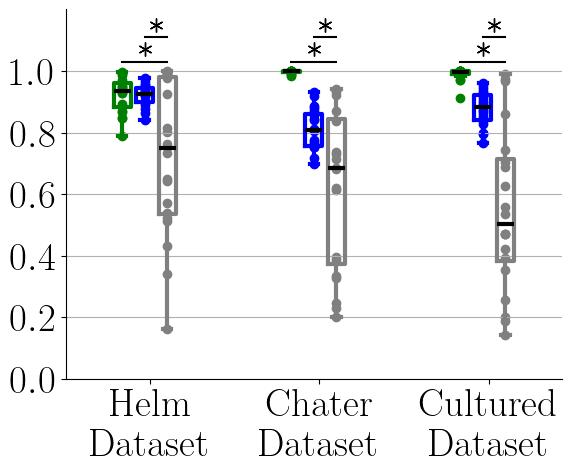

In [27]:
c='blue'
c2='green'
c3='gray'
bp1 = plt.boxplot(recall_normal,positions=[0.5],boxprops=dict(linewidth=3, color=c2,),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_normal)*0.5,recall_normal,c=c2)

bp2 = plt.boxplot(recall_better,positions=[0.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_better)*0.7,recall_better,c=c)

bp3 = plt.boxplot(recall_BH,positions=[0.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_BH)*0.9,recall_BH,c=c3)

plt.boxplot(recall_normalG,positions=[2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_normalG)*2,recall_normalG,c=c2)

plt.boxplot(recall_betterG,positions=[2.2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_betterG)*2.2,recall_betterG,c=c)

plt.boxplot(recall_BG,positions=[2.4],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_BG)*2.4,recall_BG,c=c3)

plt.boxplot(recall_normalC,positions=[3.5],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_normalC)*3.5,recall_normalC,c=c2)

plt.boxplot(recall_betterC,positions=[3.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_betterC)*3.7,recall_betterC,c=c)

plt.boxplot(recall_BC,positions=[3.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(recall_BC)*3.9,recall_BC,c=c3)



ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks([0.75,2.25,3.75],['Helm  \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot((0.5,0.9),(1.03,1.03),'k')
plt.plot(0.7,1.07,marker=(6, 2, 0),c='k',ms=10)

plt.plot((0.7,0.9),(1.11,1.11),'k')
plt.plot(0.8,1.15,marker=(6, 2, 0),c='k',ms=10)

plt.plot((2.0,2.4),(1.03,1.03),'k')
plt.plot(2.2,1.07,marker=(6, 2, 0),c='k',ms=10)

plt.plot((2.2,2.4),(1.11,1.11),'k')
plt.plot(2.3,1.15,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.5,3.9),(1.03,1.03),'k')
plt.plot(3.7,1.07,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.7,3.9),(1.11,1.11),'k')
plt.plot(3.8,1.15,marker=(6, 2, 0),c='k',ms=10)

plt.ylim([0,1.2])
plt.grid(axis = 'y')
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])

In [28]:
stats.ttest_ind(f1_BC,f1_normalC)

TtestResult(statistic=-4.663254527399557, pvalue=3.778890715147676e-05, df=38.0)

## Fig 3e

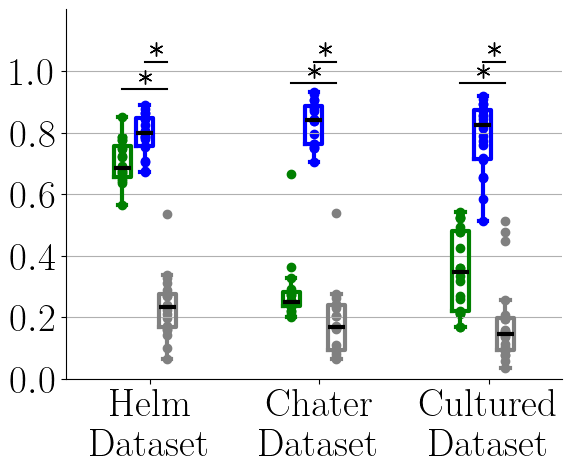

In [29]:
c='blue'
c2='green'
c3='gray'
bp1 = plt.boxplot(prec_normal,positions=[0.5],boxprops=dict(linewidth=3, color=c2,),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_normal)*0.5,prec_normal,c=c2)

bp2 = plt.boxplot(prec_better,positions=[0.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_better)*0.7,prec_better,c=c)

bp3 = plt.boxplot(prec_BH,positions=[0.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_BH)*0.9,prec_BH,c=c3)

plt.boxplot(prec_normalG,positions=[2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_normalG)*2,prec_normalG,c=c2)

plt.boxplot(prec_betterG,positions=[2.2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_betterG)*2.2,prec_betterG,c=c)

plt.boxplot(prec_BG,positions=[2.4],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_BG)*2.4,prec_BG,c=c3)

plt.boxplot(prec_normalC,positions=[3.5],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_normalC)*3.5,prec_normalC,c=c2)

plt.boxplot(prec_betterC,positions=[3.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_betterC)*3.7,prec_betterC,c=c)

plt.boxplot(prec_BC,positions=[3.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(prec_BC)*3.9,prec_BC,c=c3)



ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks([0.75,2.25,3.75],['Helm  \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot((0.5,0.9),(0.94,0.94),'k')
plt.plot((0.7,0.9),(1.03,1.03),'k')
plt.plot(0.8,1.07,marker=(6, 2, 0),c='k',ms=10)
plt.plot(0.7,0.98,marker=(6, 2, 0),c='k',ms=10)

plt.plot((2,2.4),(0.96,0.96),'k')
plt.plot(2.2,1.0,marker=(6, 2, 0),c='k',ms=10)
plt.plot((2.2,2.4),(1.03,1.03),'k')
plt.plot(2.3,1.07,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.5,3.9),(0.96,0.96),'k')
plt.plot(3.7,1.0,marker=(6, 2, 0),c='k',ms=10)
plt.plot((3.7,3.9),(1.03,1.03),'k')
plt.plot(3.8,1.07,marker=(6, 2, 0),c='k',ms=10)

plt.ylim([0,1.2])
plt.grid(axis = 'y')

plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.show()

In [30]:
stats.ttest_ind(prec_BC,prec_betterC)

TtestResult(statistic=-14.989923844308999, pvalue=1.539988702189363e-17, df=38.0)

## Fig 3f

([<matplotlib.axis.YTick at 0x17ecaf550>,
 [Text(0, 0.0, '$\\mathdefault{0.0}$'),
  Text(0, 0.2, '$\\mathdefault{0.2}$'),
  Text(0, 0.4, '$\\mathdefault{0.4}$'),
  Text(0, 0.6, '$\\mathdefault{0.6}$'),
  Text(0, 0.8, '$\\mathdefault{0.8}$'),
  Text(0, 1.0, '$\\mathdefault{1.0}$')])

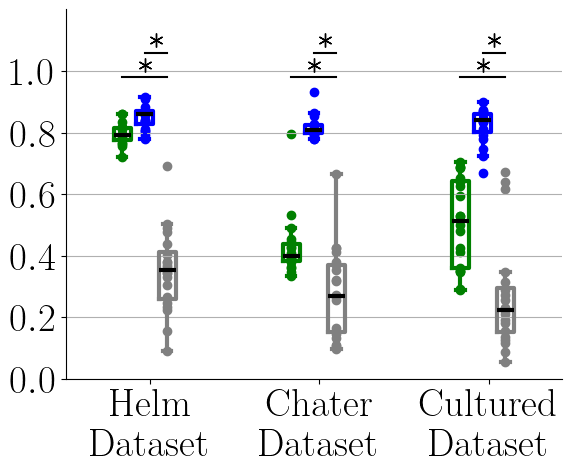

In [31]:
c='blue'
c2='green'
c3='gray'
bp1 = plt.boxplot(f1_normal,positions=[0.5],boxprops=dict(linewidth=3, color=c2,),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_normal)*0.5,f1_normal,c=c2)

bp2 = plt.boxplot(f1_better,positions=[0.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_better)*0.7,f1_better,c=c)

bp3 = plt.boxplot(f1_BH,positions=[0.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_BH)*0.9,f1_BH,c=c3)

plt.boxplot(f1_normalG,positions=[2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_normalG)*2,f1_normalG,c=c2)

plt.boxplot(f1_betterG,positions=[2.2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_betterG)*2.2,f1_betterG,c=c)

plt.boxplot(f1_BG,positions=[2.4],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_BG)*2.4,f1_BG,c=c3)

plt.boxplot(f1_normalC,positions=[3.5],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_normalC)*3.5,f1_normalC,c=c2)

plt.boxplot(f1_betterC,positions=[3.7],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_betterC)*3.7,f1_betterC,c=c)

plt.boxplot(f1_BC,positions=[3.9],boxprops=dict(linewidth=3, color=c3),
            capprops=dict(linewidth=3,color=c3),
            whiskerprops=dict(linewidth=3,color=c3),
            flierprops=dict(linewidth=3,color=c3, markeredgecolor=c3),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(f1_BC)*3.9,f1_BC,c=c3)


ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks([0.75,2.25,3.75],['Helm  \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.plot((0.5,0.9),(0.98,0.98),'k')
plt.plot(0.7,1.02,marker=(6, 2, 0),c='k',ms=10)

plt.plot((0.7,0.9),(1.06,1.06),'k')
plt.plot(0.8,1.10,marker=(6, 2, 0),c='k',ms=10)

plt.plot((2,2.4),(0.98,0.98),'k')
plt.plot(2.2,1.02,marker=(6, 2, 0),c='k',ms=10)

plt.plot((2.2,2.4),(1.06,1.06),'k')
plt.plot(2.3,1.10,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.5,3.9),(0.98,0.98),'k')
plt.plot(3.7,1.02,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.7,3.9),(1.06,1.06),'k')
plt.plot(3.8,1.10,marker=(6, 2, 0),c='k',ms=10)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.ylim([0,1.2])
plt.grid(axis = 'y')
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])

# Figure 4

In [33]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Tool/'
Im1 = []
Im2 = []
for i in range(10):
    j = i+110
    m1 = skio.imread(bDir+str(j)+'.png')
    mseg = sk.measure.label(m1)
    img = skio.imread(Dir+str(j)+'.png')
    mm = np.zeros_like(img)

    for m in range(1,mseg.max()+1):
        OL = []
        Mask = []
        for k in os.listdir(tDir+str(j)+'/'):
            if('Mask' in k):
                mm = skio.imread(tDir+str(j)+'/'+k)
                OL.append(np.sum(mm*(mseg==m)))
                Mask.append(tDir+str(j)+'/'+k)
        if(sum(np.array(OL)>0)==1):
            mm = skio.imread(Mask[np.where(np.array(OL)>0)[0][0]])
            Im1.append(np.mean(img[mseg==m]))
            Im2.append(np.mean(img[mm>0]))
            
hIm1 = Im1
hIm2 = Im2

In [34]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Tool/'
Im1 = []
Im2 = []
for j in range(10):
    m1 = skio.imread(bDir+str(j)+' spines.png')
    mseg = sk.measure.label(m1)
    img = skio.imread(Dir+str(j)+'.png')
    mm = np.zeros_like(img)

    for m in range(1,mseg.max()+1):
        OL = []
        Mask = []
        for k in os.listdir(tDir+str(j)+'/Spine/'):
            if('Mask' in k):
                mm = skio.imread(tDir+str(j)+'/Spine/'+k)
                OL.append(np.sum(mm*(mseg==m)))
                Mask.append(tDir+str(j)+'/Spine/'+k)
        if(sum(np.array(OL)>0)==1):
            mm = skio.imread(Mask[np.where(np.array(OL)>0)[0][0]])
            Im1.append(np.mean(img[mseg==m]))
            Im2.append(np.mean(img[mm>0]))
            
cIm1 = Im1
cIm2 = Im2

In [35]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Tool/'
Im1 = []
Im2 = []
for i in range(10):
    j = i
    m1 = skio.imread(bDir+str(j)+'.png')
    mseg = sk.measure.label(m1)[:480,:480]
    img = skio.imread(Dir+str(j)+'.png')

    for m in range(1,mseg.max()+1):
        OL = []
        Mask = []
        for k in os.listdir(tDir+str(j)+'/Spine/'):
            if('Mask' in k):
                mm = skio.imread(tDir+str(j)+'/Spine/'+k)
                OL.append(np.sum(mm*(mseg==m)))
                Mask.append(tDir+str(j)+'/Spine/'+k)
        if(sum(np.array(OL)>0)==1):
            mm = skio.imread(Mask[np.where(np.array(OL)>0)[0][0]])
            Im1.append(np.mean(img[mseg==m]))
            Im2.append(np.mean(img[mm>0]))

In [36]:
stats.linregress(cIm1,cIm2)

LinregressResult(slope=1.1843537189726334, intercept=0.49932628831403036, rvalue=0.8925713005465208, pvalue=7.776791813216405e-56, stderr=0.047902975935358146, intercept_stderr=1.6007866904463675)

In [37]:
x = np.arange(0, 160,20)
f = lambda x : 1.0002897001348594*x + 2.598540025058867
fg = lambda x : 1.3004791688961268*x + -30.2540714392077
fh = lambda x : 1.0129585755008774*x + -2.1545656580768053
fc = lambda x : 1.189902747279752*x + 1.301188219045251

## Fig 4a

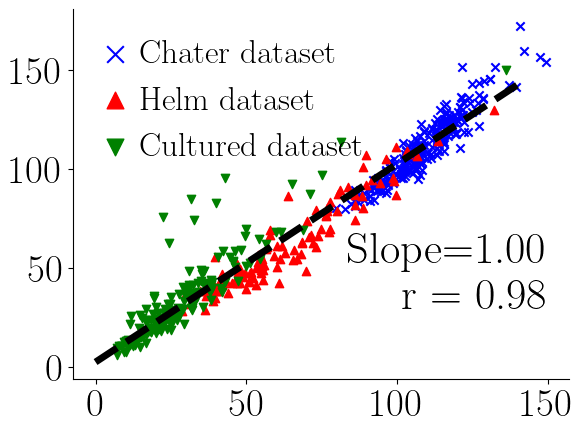

In [38]:
plt.scatter(Im1,Im2,c='b',marker='x',label='Chater dataset')
plt.scatter(hIm1,hIm2,c='r',marker='^',label='Helm dataset')
plt.scatter(cIm1,cIm2,c='g',marker='v',label='Cultured dataset')
plt.plot(x,f(x),lw=5,c='k',ls='--')
plt.text(150,30,'Slope=1.00 \n r = 0.98',fontsize=32,horizontalalignment='right',)
plt.legend(fontsize=24,frameon=False,handlelength=0.7,handletextpad=0.4,
                columnspacing=1,markerscale=2)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

In [39]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Tool/'
for i in range(110,120):
    m1 = skio.imread(bDir+str(i)+'.png')
    m2 = skio.imread(uDir+str(i)+'.jpg')
    labeled_img = sk.measure.label(m2>100)
    TrueAmt = np.max(sk.measure.label(m1))
    Pos = np.max(labeled_img)
    tPos = 0
    aPos = Pos
    for k in range(Pos):
        if(np.sum(labeled_img==k)<10):
            aPos -= 1
        if(np.logical_and(labeled_img==k,m1).any() and np.sum(labeled_img==k)>10):
            tPos+=1
    Prec = tPos/aPos
    Rec  = min(tPos/TrueAmt,1)
    print('Positive:',aPos)
    print('True Pos:', tPos)
    print('False Pos:', aPos-tPos)
    print('Prec:',tPos/aPos)
    print('Recall:',min(tPos/TrueAmt,1))
    print('F1:',2*Prec*Rec/(Prec+Rec))

Positive: 30
True Pos: 17
False Pos: 13
Prec: 0.5666666666666667
Recall: 1
F1: 0.7234042553191489
Positive: 33
True Pos: 8
False Pos: 25
Prec: 0.24242424242424243
Recall: 1
F1: 0.3902439024390244
Positive: 29
True Pos: 10
False Pos: 19
Prec: 0.3448275862068966
Recall: 1
F1: 0.5128205128205129
Positive: 21
True Pos: 15
False Pos: 6
Prec: 0.7142857142857143
Recall: 1
F1: 0.8333333333333333
Positive: 27
True Pos: 11
False Pos: 16
Prec: 0.4074074074074074
Recall: 0.9166666666666666
F1: 0.5641025641025641
Positive: 49
True Pos: 22
False Pos: 27
Prec: 0.4489795918367347
Recall: 1
F1: 0.6197183098591549
Positive: 20
True Pos: 16
False Pos: 4
Prec: 0.8
Recall: 1.0
F1: 0.888888888888889
Positive: 36
True Pos: 23
False Pos: 13
Prec: 0.6388888888888888
Recall: 1
F1: 0.7796610169491525
Positive: 37
True Pos: 19
False Pos: 18
Prec: 0.5135135135135135
Recall: 1
F1: 0.6785714285714285
Positive: 23
True Pos: 12
False Pos: 11
Prec: 0.5217391304347826
Recall: 1
F1: 0.6857142857142856


In [40]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Goda/Tool/'
sDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/'
F1   = []
Rec  = []
Prec = []

F1b   = []
Recb  = []
Precb = []
for i in range(10):
    j = i
    img = skio.imread(Dir+str(j)+'.png')
    mm = skio.imread(bDir+str(j)+'.png')
    am = ((mm >= 250)*1).astype(np.float64)
    am[am==0] = math.nan
    am = am[:480,:480]
    
    xmax = np.where(~np.isnan(am))[0].max()
    ymax = np.where(~np.isnan(am))[1].max()
    
    xmin = np.where(~np.isnan(am))[0].min()
    ymin = np.where(~np.isnan(am))[1].min()
    
    aml = am[xmin:xmax,ymin:ymax]
    
    mm = np.zeros_like(img[:,:,0])
    for k in os.listdir(tDir+str(j)+'/Spine/'):
        if('Mask' in k):
            mm += skio.imread(tDir+str(j)+'/Spine/'+k)
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan

    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(am)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(am)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(am)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)

    F1.append(f1)
    Prec.append(prec)
    Rec.append(rec)
    
    mm = Image.open(uDir+str(j)+'.jpg')

    # Resize the image to 480 x 480 using ANTIALIAS filter for downsampling
    mm = np.array(mm.resize((480, 480), Image.LANCZOS))
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan
    am2 = am2[xmin:xmax,ymin:ymax]
    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(aml)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(aml)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(aml)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)

    F1b.append(f1)
    Precb.append(prec)
    Recb.append(rec)

In [41]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Helm/Tool/'
HF1   = []
HRec  = []
HPrec = []

HF1b   = []
HRecb  = []
HPrecb = []
for i in range(10):
    j = i+110
    img = skio.imread(Dir+str(j)+'.png')
    mm = skio.imread(bDir+str(j)+'.png')
    am = ((mm >= 250)*1).astype(np.float64)
    am[am==0] = math.nan
    
    xmax = np.where(~np.isnan(am))[0].max()
    ymax = np.where(~np.isnan(am))[1].max()
    
    xmin = np.where(~np.isnan(am))[0].min()
    ymin = np.where(~np.isnan(am))[1].min()
    
    aml = am[xmin:xmax,ymin:ymax]

    mm = np.zeros_like(img)
    for k in os.listdir(tDir+str(j)+'/'):
        if('Mask' in k):
            mm += skio.imread(tDir+str(j)+'/'+k)
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan

    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(am)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(am)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(am)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)
    
    HF1.append(f1)
    HPrec.append(prec)
    HRec.append(rec)
    
    mm = skio.imread(uDir+str(j)+'.jpg')
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan
    am2 = am2[xmin:xmax,ymin:ymax]
    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(aml)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(aml)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(aml)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)

    HF1b.append(f1)
    HPrecb.append(prec)
    HRecb.append(rec)

In [42]:
Dir  = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Raw/'
bDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Manual/'
uDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/U-Net/'
tDir = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/SpineROI/Cultured/Tool/'
CF1   = []
CRec  = []
CPrec = []

CF1b   = []
CRecb  = []
CPrecb = []
for j in range(11):
    img = rgb_to_grayscale(skio.imread(Dir+str(j)+'.png'))
    mm = skio.imread(bDir+str(j)+' spines.png')
    am = ((mm >= 250)*1).astype(np.float64)
    am[am==0] = math.nan
    
    xmax = np.where(~np.isnan(am))[0].max()
    ymax = np.where(~np.isnan(am))[1].max()
    
    xmin = np.where(~np.isnan(am))[0].min()
    ymin = np.where(~np.isnan(am))[1].min()
    
    aml = am[xmin:xmax,ymin:ymax]

    mm = np.zeros_like(img)
    for k in os.listdir(tDir+str(j)+'/Spine/'):
        if('Mask' in k):
            mm += skio.imread(tDir+str(j)+'/Spine/'+k)
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan

    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(am)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(am)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(am)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)
    
    CF1.append(f1)
    CPrec.append(prec)
    CRec.append(rec)
    
    mm = skio.imread(uDir+str(j)+'.png')
    am2 = ((mm >= 250)*1).astype(np.float64)
    am2[am2==0] = math.nan
    am2 = am2[xmin:xmax,ymin:ymax]
    tp = np.sum(np.logical_and(~np.isnan(am2),~np.isnan(aml)))
    fp = np.sum(np.logical_and(~np.isnan(am2),np.isnan(aml)))
    fn = np.sum(np.logical_and(np.isnan(am2),~np.isnan(aml)))

    prec = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*prec*rec/(prec+rec)

    CF1b.append(f1)
    CPrecb.append(prec)
    CRecb.append(rec)
print(CF1)

[0.7868694955964772, 0.7206244864420706, 0.7132493318060329, 0.6849226804123711, 0.7160345173590208, 0.7447711427705365, 0.7631147540983606, 0.7643478260869565, 0.71253534401508, 0.7576345128453709, 0.7145293315143246]


/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_19726/1673639532.py:55: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec/(prec+rec)


In [43]:
Manual1 = [[11.22,13.097,10.927,10.629,11.626,10.54,9.212,9.613],
[29.203, 28.799,26.065,25.883,28.603,25.598,25.417,30.913],
[26.099,23.627,22.744,23.744,16.799,19.701,17.919,17.122],
[11.923,12.139,11.821,12.128,10.472,10.984,12.019,11.632],
[12.506,14.785,13.415,13.694,14.234,13.879,14.438,13.804],
[26.898,23.581,33.479,34.883,25.185,24.472,28.955,25.098],
[22.161,23.454,16.437,17.247,20.523,20.052,18.879,19.385],
[50.15,70.18,52.43,81.843,62.117,56.203,56.043,59.1],
[19.398,25.941,20.952,28.033,22.974,28.283,21.572,29.535],
[24.514,23.902,29.854,44.413,31.747,23.415,27.012,27.162],
[27.671,33.78,31.701,33.263,34.438,30.491,32.499,33.248],
[23.711,23.083,20.253,22.149,21.964,23.739,20.059,21.285],
[10.101,9.64,10.305,10.442,11.234,10.087,10.917,10.507],
[26.384,27.563,33.146,26.745,35.63,40.49,25.692,30.669],
[21.134,24.216,22.462,21.818,17.852,20.675,19.563,19.176]]
Manual1 = np.array(Manual1)

Manual2 = [[51.974,52.428,74.588,36.944,36.979,45.901,47.635,45.329],
[39.59,43.86,43.01,37.8,40.29,36.93,47.235,45.565],
[53.821,35.33,43.074,34.482,41.191,49.082,56.872,67.793],
[40.369,37.332,45.869,44.458,68.051,62.458,58.836,49.822],
[30.394,31.875,26.841,36.379,38.735,36.909,36.314,32.629],
[21.223,20.594,20.039,21.551,22.418,22.691,31.227,35.273],
[24.797,25.857,24.748,26.85,27.311,27.57,32.21,37.29],
[45.132,32.766,41.594,45.774,33.913,34.248,32.321,44.382],
[37.411,40.198,33.786,50.343,52.444,38.016,39.29,46.702],
[45.049,36.946,39.838,49.333,47.279,56.966,64.417,49.75],
[24.681,25.346,25.027,29.202,29.309,29.707,35.495,29.144],
[43.627,40.041,42.337,41.409,33.58,43.109,34.43,29.114],
[34.228,37.622,31.075,30.595,29.312,32.535,50.084,43.58],
[52.853,44.045,54.904,35.171,37.231,36.538,35.61,28.688],
[22.889,22.419,30.265,36.632,32.028,29.115,29.174,36.964],
[24.625,29.949,25.032,25.617,27.597,26.237,25.684,24.261],
[31.695,35.352,29.59,32.748,32.743,40.433,45.557,45.624],
[26.157,32.581,27.029,25.643,30.914,31.848,34.333,27.314],
[38.477,40.435,33.676,41.909,51.495,40.06,41.554,40.282]]
Manual2 = np.array(Manual2)

Manual3 = [[17.868,19.74,21.234,23.266,24.958,23.434,28.982,26.53],
[49.539,45.97,38.578,51.383,40.506,49.476,51.763,56.695],
[29.003,35.296,33.392,40.341,35.096,35.518,35.904,44.647],
[38.226,37.761,33.916,42.455,24.713,34.2,32.677,31.79],
[32.784,39.677,38.223,32.394,29.11,32.335,31.219,38.89],
[21.729,19.114,19.92,23.342,20.465,35.332,34.148,26.095],
[51.174,56.126,52.967,49.059,60.128,60.262,67.226,60.626],
[26.966,29.039,27.259,38.259,38.893,45.93,60.115,50.851],
[24.774,28.687,31.494,30.579,34.445,38.369,31.181,29.268],
[32.286,37.19,30.528,34.864,39.557,44.33,44.393,48.88],
[22.524,25.261,22.613,23.317,30.082,33.828,24.903,32.645],
[23.221,22.483,22.151,27.006,22.877,24.95,26.401,20.262],
[19.287,20.126,20.054,26.628,24.862,24.054,15.383,18.51],
[68.66,78.268,89.899,74.445,81.781,76.355,59.052,55.637],
[32.084,32.724,28.919,37.055,33.745,35.918,39.278,40.493],
[39.934,40.426,35.653,41.944,39.806,40.646,50.398,45.447],
[29.314,35.768,35.066,39.204,34.939,36.035,41.714,40.585],
[12.689,13.304,12.302,14.801,16.143,15.78,14.616,17.993],
[22.499,24.778,29.827,27.885,26.677,27.19,27.115,29.426]]
Manual3 = np.array(Manual3)

Spyden1 = [[17.8447653429602,19.3971119133574,15.4837545126353,14.4368231046931,15.4801444043321,14.2527075812274,13.7039711191335,13.927797833935],
[51.5347593582887,52.427807486631,48.7860962566844,50.2085561497326,53.9732620320855,48.0695187165775,46.0320855614973,45.6951871657754],
[55.6241610738255,42.9328859060402,35.3557046979865,36.731543624161,26.2617449664429,28.1812080536912,28.4630872483221,26.5302013422818],
[18.5195530726256,17.6927374301675,14.558659217877,12.8826815642458,12.268156424581,13.4525139664804,13.2569832402234,15.0279329608938],
[26.9620853080568,38.9241706161137,45.2180094786729,52.2464454976303,41.303317535545,39.3696682464455,35.7582938388625,35.4549763033175],
[29.9826839826839,26.5887445887445,36.1774891774891,38.6580086580086,26.3722943722943,27.2683982683982,29.5064935064935,23.6580086580086],
[37.9106145251396,52.6703910614525,62.2346368715083,61.8994413407821,56.4357541899441,54.7988826815642,61.5474860335195,61.0335195530726],
[67.8374384236453,93.8620689655172,78.7733990147783,115.11330049261,85.1280788177339,76.2807881773399,74.7044334975369,87.9261083743842],
[30.3537414965986,38.2993197278911,31.4421768707483,39.78231292517,31.3673469387755,35.7891156462585,26.8435374149659,35.7278911564625],
[35.108626198083,38.1118210862619,47.6677316293929,72.3961661341853,50.4856230031948,40.6453674121405,46.5559105431309,46.8913738019169],
[56.3128491620111,64.217877094972,63.7150837988826,65.0893854748603,60.2737430167597,52.6703910614525,53.804469273743,53.3240223463687],
[39.3918918918918,36.7027027027027,33.5225225225225,34.6891891891891,33.8423423423423,34.1351351351351,30.2837837837837,31.536036036036],
[17.7434782608695,15.7391304347826,20.2391304347826,23.3130434782608,25.0826086956521,22.8521739130434,25.2434782608695,32.4652173913043],
[44.9911894273127,49.8722466960352,63.885462555066,59.9559471365638,68.6784140969163,81.669603524229,56.9383259911894,65.2907488986784],
[32.8609271523178,28.9271523178807,20.887417218543,18.1920529801324,18.682119205298,15.8741721854304,16.6158940397351,15.7549668874172]]

Spyden1 = np.array(Spyden1)

Spyden1Alt = [[18.336633663366300,20.455445544554500,16.52970297029700,15.163366336633700,19.81188118811880,15.287128712871300,22.52970297029700,25.113861386138600],
[54.59288537549410,56.50592885375490,50.44268774703560,49.84584980237150,50.81818181818180,46.52173913043480,49.715415019762800,39.1501976284585],
[56.535714285714300,42.91428571428570,40.02857142857140,42.57857142857140,28.7,35.18571428571430,35.52857142857140,35.378571428571400],
[18.47826086956520,18.48447204968940,16.055900621118000,15.894409937888200,15.540372670807500,16.385093167701900,16.41614906832300,19.428571428571400],
[24.822580645161300,36.81182795698930,37.25268817204300,37.24731182795700,28.881720430107500,27.596774193548400,29.35483870967740,24.63978494623660],
[30.129464285714300,26.040178571428600,37.075892857142900,38.80357142857140,27.09375,28.825892857142900,27.915178571428600,26.799107142857100],
[42.17613636363640,54.88636363636360,58.89204545454550,58.90340909090910,52.63068181818180,45.85227272727270,48.64204545454550,47.77272727272730],
[70.87912087912090,102.9010989010990,79.52747252747250,115.18131868131900,83.52197802197800,76.51648351648350,64.2032967032967,77.47252747252750],
[30.44943820224720,35.79213483146070,32.37640449438200,42.640449438202200,37.43258426966290,39.37640449438200,27.230337078651700,36.96629213483150],
[40.3034188034188,40.376068376068400,51.35470085470090,80.41880341880340,53.05555555555560,41.995726495726500,36.3974358974359,34.39316239316240],
[48.3109243697479,54.36974789915970,55.739495798319300,59.424369747899200,55.10504201680670,51.76890756302520,40.260504201680700,49.180672268907600],
[31.269076305220900,28.698795180722900,29.65461847389560,32.31325301204820,31.224899598393600,31.253012048192800,22.23694779116470,25.453815261044200],
[15.333333333333300,14.152380952381000,16.41269841269840,16.501587301587300,18.33968253968250,18.692063492063500,25.01904761904760,26.08888888888890],
[41.490196078431400,46.04248366013070,53.754901960784300,46.51307189542480,56.05555555555560,67.50326797385620,50.794117647058800,55.64705882352940],
[35.71098265895950,34.6242774566474,32.23121387283240,30.0,31.260115606936400,32.421965317919100,23.99421965317920,24.92485549132950]]

Spyden1Alt = np.array(Spyden1Alt)

Spyden2 = [[66.9450980392156,60.713725490196,82.4901960784313,54.9490196078431,53.278431372549,61.0941176470588,63.9450980392156,56.3333333333333],
[26.2801932367149,23.9420289855072,32.9420289855072,24.487922705314,32.4202898550724,33.2705314009661,34.2270531400966,32.6135265700483],
[82.7366946778711,59.3109243697479,65.126050420168,59.5518207282913,73.6862745098039,83.6750700280112,106.072829131652,105.431372549019],
[74.2821917808219,77.9616438356164,81.0493150684931,83.4273972602739,98.9479452054794,99.9808219178082,107.865753424657,102.512328767123],
[60.0836363636363,67.1818181818181,56.7672727272727,68.2145454545454,67.170909090909,80.7381818181818,85.7672727272727,86.1272727272727],
[26.9868421052631,24.9802631578947,24.9144736842105,27.1315789473684,26.7302631578947,26.6184210526315,29.4078947368421,29.0394736842105],
[68.7749287749287,77.7321937321937,66.3048433048433,75.9800569800569,76.8433048433048,89.002849002849,102.957264957264,111.262108262108],
[85.3028391167192,65.2776025236593,73.5488958990536,88.3880126182965,68.2807570977917,59.1388012618296,51.7570977917981,65.8738170347003],
[59.1785714285714,60.4571428571428,54.4714285714285,69.0714285714285,76.0357142857142,47.9785714285714,46,45.7],
[63.9931740614334,68.4675767918088,73.334470989761,79.5972696245733,83.5597269624573,91.3720136518771,106.580204778157,105.634812286689],
[43.088772845953,36.8146214099216,38.3028720626631,40.953002610966,43.7624020887728,39.7702349869451,39.8825065274151,36.0861618798955],
[73.065934065934,74.898901098901,70.243956043956,77.0681318681318,87.3780219780219,85.6175824175824,79.5252747252747,81.3758241758241],
[71.4712041884816,76.6151832460733,66.044502617801,64.8193717277486,67.3900523560209,74.0078534031413,78.6492146596858,68.7853403141361],
[86.0251572327044,70.251572327044,86.1698113207547,53.4716981132075,50.2578616352201,45.1132075471698,31.2767295597484,15.3836477987421],
[44.2115384615384,48.8397435897435,49.1698717948717,63.2339743589743,62.7179487179487,67.2179487179487,77.9711538461538,80.8301282051282],
[58.4194915254237,59.8728813559322,77.3262711864406,66.8516949152542,62.5,70.1101694915254,79.1483050847457,75.6864406779661],
[44.7763975155279,47.1490683229813,42.3664596273291,40.1490683229813,41.5031055900621,43.4658385093167,47.1428571428571,44.2919254658385],
[33.9832775919732,42.1505016722408,38.0167224080267,41.1839464882943,44.0468227424749,57.3545150501672,56.6989966555183,56.7725752508361],
[56.5754716981132,59.0542452830188,56.9080188679245,66.8231132075471,80.441037735849,76.9339622641509,83.5518867924528,75.2806603773584]]

Spyden2 = np.array(Spyden2)

Spyden3 = [[29.8819444444444,35.3125,34.5347222222222,35.6388888888888,40.9513888888888,34.1875,40.2777777777777,38.7569444444444],
[85.0555555555555,80.2037037037037,69.3641975308642,91.0185185185185,72.253086419753,87.7283950617283,87.6913580246913,98.395061728395],
[63.0384615384615,63.0192307692307,57.451923076923,56.6442307692307,62.8365384615384,53.3942307692307,51.0961538461538,51.0480769230769],
[70.1420118343195,71.8579881656804,74,81.3727810650887,78.6153846153846,109.213017751479,101.390532544378,84.396449704142],
[48.9502762430939,60.8342541436464,60.8508287292817,55.4530386740331,46.8618784530386,49.1160220994475,47.4861878453038,68.8729281767955],
[43.1465517241379,37.2241379310344,36.5603448275862,44.4655172413793,37.4396551724137,76.7413793103448,81.7068965517241,46.301724137931],
[76.6373626373626,89.3736263736263,79.576923076923,73.0989010989011,85.3956043956044,85.7747252747252,76.7637362637362,82.0054945054945],
[43.1525423728813,49.0056497175141,46.1299435028248,63.1016949152542,58.7909604519774,76.5875706214689,93.1920903954802,83.4915254237288],
[33.3084577114427,39.1343283582089,45.5621890547263,41.4079601990049,49.8109452736318,56.1940298507462,36.0597014925373,28.3432835820895],
[56.7673469387755,69.6204081632653,55.3755102040816,63.2244897959183,70.0816326530612,78.2285714285714,76.4448979591836,82.334693877551],
[55.7777777777777,61.4795321637426,51.6432748538011,61.485380116959,82.0643274853801,88.2456140350877,70.1871345029239,94.2456140350877],
[39.3057851239669,39.7851239669421,37.9669421487603,42.4876033057851,33.6528925619834,27.7768595041322,33.2644628099173,26.3801652892561],
[45.9365079365079,48.2063492063492,50.8809523809523,63.9682539682539,60.0555555555555,79.7857142857142,63.2936507936507,63.7301587301587],
[112.4932735426,118.650224215246,138.780269058295,112.578475336322,121.67264573991,121.430493273542,84.9686098654708,88.1793721973094],
[70.9663865546218,74.2310924369747,71.126050420168,84.0336134453781,79.9453781512605,89.9369747899159,103.735294117647,103.516806722689],
[70.8837209302325,72.8255813953488,55.7558139534883,74.1802325581395,73.1860465116279,76.9418604651162,91.8953488372093,82.4593023255813],
[54.9189189189189,65.9189189189189,60.5189189189189,73.9459459459459,66.4486486486486,67.0432432432432,71.8378378378378,63.8054054054054],
[25.9071428571428,27.2785714285714,22.4785714285714,28.15,33.8285714285714,34.6,28.3714285714285,39.0928571428571],
[40.6428571428571,42.7857142857142,50.6479591836734,46.4948979591836,44.8520408163265,44.6173469387755,46.0765306122448,50.3724489795918]]

Spyden3 = np.array(Spyden3)

Spyden3Alt = [[28.062111801242200,32.63354037267080,32.13664596273290,32.5527950310559,38.1055900621118,30.937888198757800,36.5527950310559,35.11180124223600],
[82.40588235294120,77.82352941176470,66.87058823529410,87.00588235294120,68.4235294117647,82.55294117647060,80.92941176470590,89.90588235294120],
[71.31617647058820,73.79411764705880,72.97058823529410,74.625,76.875,67.56617647058820,67.75735294117650,65.97058823529410],
[70.39226519337020,73.30386740331490,76.33149171270720,79.85082872928180,74.58011049723760,104.03867403314900,97.46408839779010,82.6353591160221],
[47.09644670050760,57.48223350253810,56.46700507614210,50.27918781725890,41.15228426395940,43.72081218274110,42.23857868020310,57.84263959390860],
[39.358620689655200,35.15862068965520,34.317241379310300,41.213793103448300,35.179310344827600,71.28965517241380,76.0,46.13103448275860],
[77.47208121827410,89.98477157360410,79.94923857868020,75.80710659898480,87.6497461928934,87.60406091370560,81.69543147208120,84.28934010152280],
[40.03482587064680,45.81094527363180,43.09452736318410,59.74626865671640,56.85572139303480,72.3681592039801,91.14925373134330,78.86069651741290],
[32.892682926829300,39.702439024390200,46.1609756097561,41.90731707317070,50.53658536585370,58.38048780487810,38.453658536585400,30.897560975609800],
[55.3,65.98461538461540,52.33076923076920,61.01538461538460,66.5,74.61153846153850,73.21538461538460,77.4423076923077],
[54.144444444444400,60.394444444444400,49.96111111111110,59.53888888888890,78.87777777777780,85.15,67.28888888888890,90.1],
[34.786259541984700,36.87786259541990,35.57251908396950,39.786259541984700,32.404580152671800,26.458015267175600,33.534351145038200,26.6793893129771],
[38.771929824561400,41.146198830409400,43.50292397660820,56.98830409356730,51.187134502924000,67.64327485380120,54.83040935672520,55.31578947368420],
[103.44444444444400,112.02592592592600,127.06666666666700,109.85185185185200,117.77037037037000,118.88888888888900,91.28888888888890,86.89259259259260],
[66.2992700729927,69.26277372262770,66.56569343065690,78.17518248175180,74.76277372262770,83.54379562043800,96.87956204379560,96.31021897810220],
[62.67487684729060,65.94581280788180,56.18226600985220,66.93103448275860,65.32512315270940,68.71428571428570,81.63546798029560,72.72906403940890],
[50.282407407407400,60.06018518518520,56.611111111111100,66.97222222222220,60.93055555555560,61.638888888888900,66.44444444444440,58.51851851851850],
[25.272058823529400,27.029411764705900,22.022058823529400,27.683823529411800,33.35294117647060,34.27205882352940,28.352941176470600,38.919117647058800],
[36.83408071748880,38.63228699551570,45.61883408071750,42.34977578475340,40.16591928251120,40.56053811659190,41.2914798206278,46.26905829596410]]

Spyden3Alt = np.array(Spyden3Alt)

## Fig 4b

/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_19726/242992726.py:43: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(Manual1, Spyden1Alt, c=np.hstack([c]*15), cmap='Reds', norm=norm, edgecolor='none',s=75,marker='x')
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_19726/242992726.py:44: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(Manual2, Spyden2, c=np.hstack([c]*19), cmap='Blues', norm=norm, edgecolor='none',s=75,marker='x')
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_19726/242992726.py:45: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the faceco

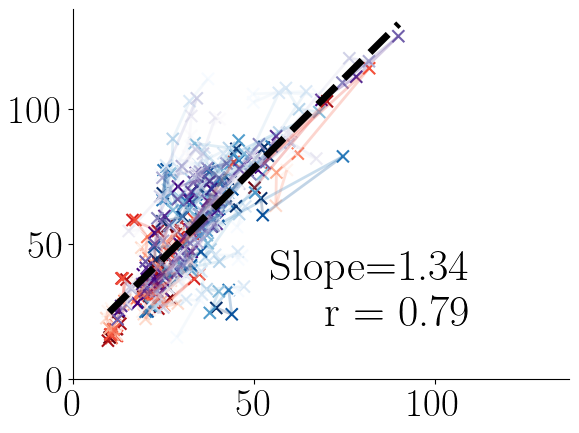

In [44]:
fig,ax = plt.subplots()
c = np.arange(8)[::-1]
norm = plt.Normalize(-8, 2*c.max())
for m,s in zip(Manual1,Spyden1Alt):
    x = m
    y = s
    c = np.arange(8)[::-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='Reds', norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    lc.set_alpha(0.25)
    line = ax.add_collection(lc)
norm = plt.Normalize(c.min(), c.max())
for m,s in zip(Manual2,Spyden2):
    x = m
    y = s
    c = np.arange(8)[::-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='Blues', norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    lc.set_alpha(0.25)
    line = ax.add_collection(lc)

for m,s in zip(Manual3,Spyden3Alt):
    x = m
    y = s
    c = np.arange(8)[::-1]
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='Purples', norm=norm)
    # Set the values used for colormapping
    lc.set_array(c)
    lc.set_linewidth(2)
    lc.set_alpha(0.25)
    line = ax.add_collection(lc)

ax.scatter(Manual1, Spyden1Alt, c=np.hstack([c]*15), cmap='Reds', norm=norm, edgecolor='none',s=75,marker='x')
ax.scatter(Manual2, Spyden2, c=np.hstack([c]*19), cmap='Blues', norm=norm, edgecolor='none',s=75,marker='x')
ax.scatter(Manual3, Spyden3Alt, c=np.hstack([c]*19), cmap='Purples', norm=norm, edgecolor='none',s=75,marker='x')

ax.set_ylim([0,Spyden3Alt.max()+10])
ax.set_xlim([0,Spyden3Alt.max()+10])

plt.plot([10,90],[10*1.336802309309762+11.326328669984889,1.336802309309762*90+11.326328669984889],'k--',lw=5)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(110,20,'Slope=1.34 \n r = 0.79',fontsize=32,horizontalalignment='right',)
plt.savefig(sDir+'TimeTrack.pdf',format='pdf',bbox_inches='tight')

## Fig 4d

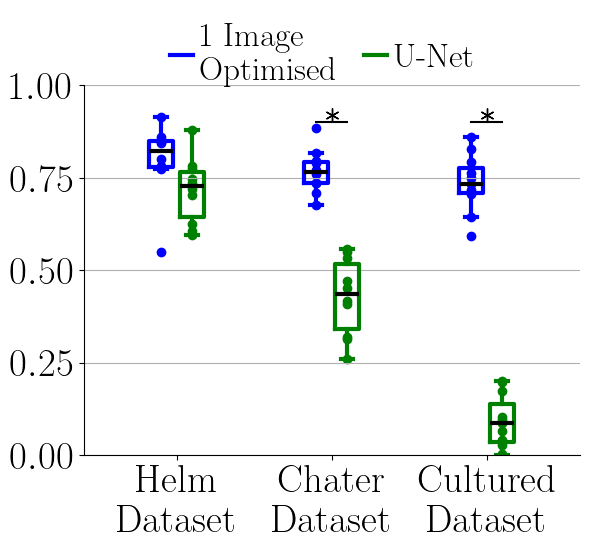

In [45]:
c = 'b'
plt.scatter(1*np.ones(10),HRec,c=c)
bp1 = plt.boxplot(HRec,positions=[1],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(HRecb,positions=[1.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(1.2*np.ones(10),HRecb,c=c2)

plt.xticks([1.1],['Goda \n Dataset'])

plt.scatter(2*np.ones(10),Rec,c=c)
plt.boxplot(Rec,positions=[2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

bp2 = plt.boxplot(Recb,positions=[2.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(2.2*np.ones(10),Recb,c=c2)

plt.scatter(3*np.ones(11),CRec,c=c)
plt.boxplot(CRec,positions=[3],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

bp2 = plt.boxplot(CRecb,positions=[3.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(3.2*np.ones(11),CRecb,c=c2)

plt.xticks([1.1,2.1,3.1],['Helm \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot((2.0,2.2),(0.9,0.9),'k')
plt.plot(2.1,0.92,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.0,3.2),(0.9,0.9),'k')
plt.plot(3.1,0.92,marker=(6, 2, 0),c='k',ms=10)

leg = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['1 Image \n Optimised', 'U-Net'],fontsize=24,
               frameon=False,ncol=3,handlelength=0.7,handletextpad=0.2,loc=1,
                columnspacing=0.8,bbox_to_anchor=(0.85,1.25))
plt.ylim([0,1])
plt.grid(axis = 'y')

## Fig 4e

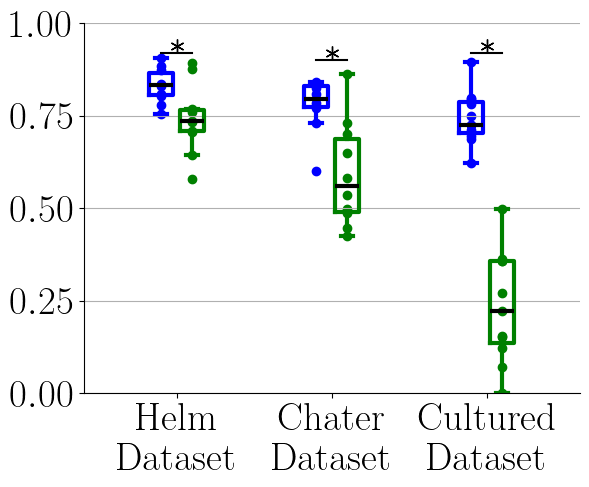

In [46]:
plt.scatter(1*np.ones(10),HPrec,c=c)
plt.boxplot(HPrec,positions=[1],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(HPrecb,positions=[1.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(1.2*np.ones(10),HPrecb,c=c2)

plt.xticks([1.1],['Goda \n Dataset'])

plt.scatter(2*np.ones(10),Prec,c=c)
plt.boxplot(Prec,positions=[2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(Precb,positions=[2.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(2.2*np.ones(10),Precb,c=c2)

plt.scatter(3*np.ones(11),CPrec,c=c)
plt.boxplot(CPrec,positions=[3],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.boxplot(CPrecb,positions=[3.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(3.2*np.ones(11),CPrecb,c=c2)

plt.xticks([1.1,2.1,3.1],['Helm \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot((2.0,2.2),(0.9,0.9),'k')
plt.plot(2.1,0.92,marker=(6, 2, 0),c='k',ms=10)

plt.plot((1.0,1.2),(0.92,0.92),'k')
plt.plot(1.1,0.94,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.0,3.2),(0.92,0.92),'k')
plt.plot(3.1,0.94,marker=(6, 2, 0),c='k',ms=10)
plt.ylim([0,1])
plt.grid(axis = 'y')

## Fig 4f

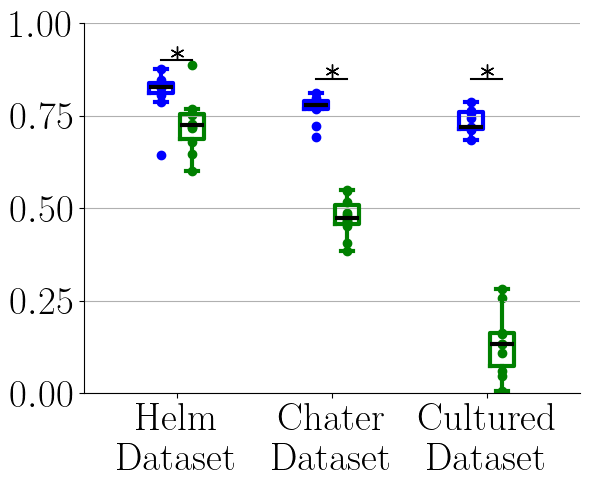

In [47]:
plt.scatter(1*np.ones(10),HF1,c=c)
plt.boxplot(HF1,positions=[1],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(HF1b,positions=[1.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(1.2*np.ones(10),HF1b,c=c2)

plt.xticks([1.1],['Goda \n Dataset'])

plt.scatter(2*np.ones(10),F1,c=c)
plt.boxplot(F1,positions=[2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(F1b,positions=[2.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(2.2*np.ones(10),F1b,c=c2)

plt.scatter(3*np.ones(11),CF1,c=c)
plt.boxplot(CF1,positions=[3],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)

plt.boxplot(np.array(CF1b)[~np.isnan(CF1b)],positions=[3.2],boxprops=dict(linewidth=3, color=c2),
            capprops=dict(linewidth=3,color=c2),
            whiskerprops=dict(linewidth=3,color=c2),
            flierprops=dict(linewidth=3,color=c2, markeredgecolor=c2),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(3.2*np.ones(11),CF1b,c=c2)

plt.xticks([1.1,2.1,3.1],['Helm \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.plot((2.0,2.2),(0.85,0.85),'k')
plt.plot(2.1,0.87,marker=(6, 2, 0),c='k',ms=10)

plt.plot((1.0,1.2),(0.9,0.9),'k')
plt.plot(1.1,0.92,marker=(6, 2, 0),c='k',ms=10)

plt.plot((3.0,3.2),(0.85,0.85),'k')
plt.plot(3.1,0.87,marker=(6, 2, 0),c='k',ms=10)
plt.ylim([0,1])
plt.grid(axis = 'y')
plt.savefig(sDir+'F1.pdf',format='pdf',bbox_inches='tight')

# Figure 5

In [50]:
camila_2017_paper_data = pd.read_excel("./Data/Puncta/smFISH_quantification_data.xlsx")
cleaned_C2017_data = cleandata(camila_2017_paper_data)
camila_data = pd.read_pickle("./Data/Puncta/camila_spydend.pkl")

In [51]:
mRNA_counts = camila_data.groupby(["Neuron","compartment","isoform"]).count()["Unnamed: 0"]
# mRNA_counts = mRNA_counts.rename(columns={"Unnamed: 0":'count'})
mRNA_total = mRNA_counts.groupby(["Neuron","compartment"]).sum()
mRNA_fractions = (mRNA_counts/mRNA_total)#.to_numpy().reshape(13,2,2)
mRNA_fractions = mRNA_fractions.reset_index()
mRNA_fractions = mRNA_fractions.rename(columns={'Unnamed: 0':'fractions'})
mRNA_fractions[tool] = tool_list[1]


mRNA_counts_c17 = cleaned_C2017_data.groupby(["Neuron","compartment","isoform"]).sum()
mRNA_total_c17 = mRNA_counts_c17.groupby(["Neuron","compartment"]).sum()
mRNA_fractions_c17 = (mRNA_counts_c17/mRNA_total_c17)
mRNA_fractions_c17 = mRNA_fractions_c17.reset_index()
mRNA_fractions_c17 = mRNA_fractions_c17.rename(columns={'Num':'fractions'})
mRNA_fractions_c17[tool] =  tool_list[0]

print("*"*20,"\n",mRNA_fractions.head(),"\n","*"*20,"\n","*"*20,"\n",mRNA_fractions_c17.head(),"\n","*"*20)
final_fractions = pd.concat((mRNA_fractions,mRNA_fractions_c17))

******************** 
    Neuron compartment isoform  fractions    Tool
0       1    neurites      E6   0.352941  SpyDen
1       1    neurites      E7   0.647059  SpyDen
2       1        soma      E6   0.454167  SpyDen
3       1        soma      E7   0.545833  SpyDen
4       2    neurites      E6   0.371429  SpyDen 
 ******************** 
 ******************** 
    Neuron compartment isoform  fractions        Tool
0       1    neurites      E6   0.125000  StarSearch
1       1    neurites      E7   0.875000  StarSearch
2       1        soma      E6   0.578125  StarSearch
3       1        soma      E7   0.421875  StarSearch
4       2    neurites      E6   0.277778  StarSearch 
 ********************


## Fig 5d,e

     1    2    3    4
1  1.0  1.0  1.0  1.0
2  1.0  1.0  1.0  1.0
3  1.0  1.0  1.0  1.0
4  1.0  1.0  1.0  1.0
1.0 [1, 3]
ns
1.0 [2, 4]
ns
kk=0
          1         2         3         4
1  1.000000  1.000000  0.002018  0.000101
2  1.000000  1.000000  0.000101  0.000003
3  0.002018  0.000101  1.000000  1.000000
4  0.000101  0.000003  1.000000  1.000000
0.002017645270010679 [1, 3]
**
3.060807620178497e-06 [2, 4]
***
kk=1


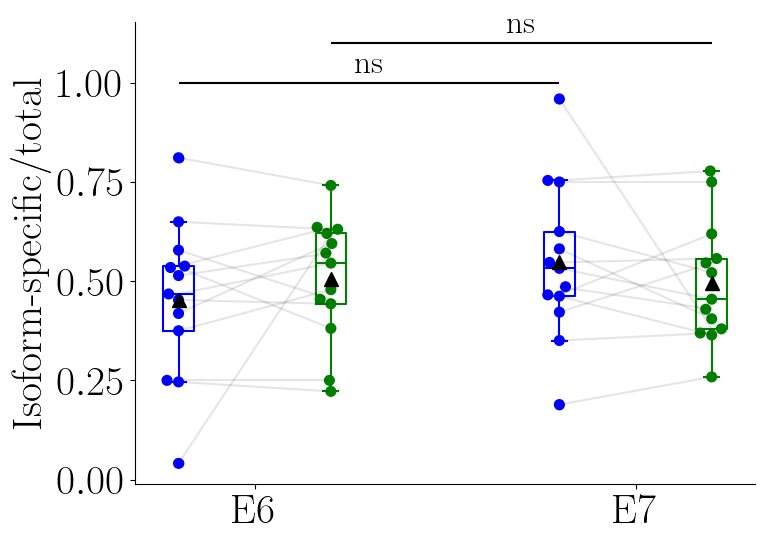

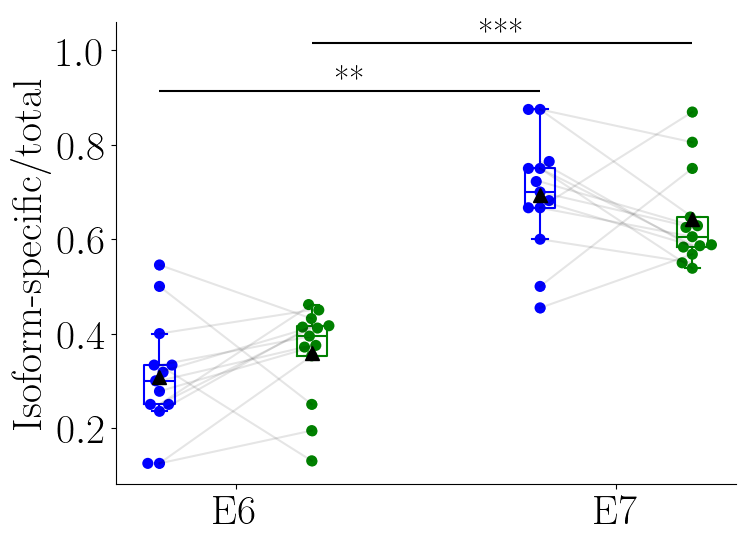

In [52]:
xlab = ""
ylab = "Isoform-specific/total"
title = "smFISH quantification in"
SwarmBoxCombo(final_fractions,
              x = "isoform",
              y = "fractions",
              fbase="Fig_5DE",
              xlabel=xlab,
              ylabel=ylab,
              title=title)

## Fig 5f

In [53]:
camila_data = pd.read_pickle("./Data/Puncta/camila_spydend.pkl")
Fonkeu_data = pd.read_pickle("./Data/Puncta/Fonkeu_mRNA_data.pkl")  
SpyDen_data = pd.read_pickle("./Data/Puncta/SpyDen_mRNA_data.pkl")  

mRNA_counts_NB = Fonkeu_data.groupby(["cell_id","compartment"]).count().PID
mRNA_total_NB = mRNA_counts_NB.groupby(["cell_id"]).sum()
mRNA_fractions_NB = (mRNA_counts_NB/mRNA_total_NB)#.to_numpy().reshape(13,2,2)
mRNA_fractions_NB = mRNA_fractions_NB.reset_index()
mRNA_fractions_NB = mRNA_fractions_NB.rename(columns={'PID':'fractions'})
mRNA_fractions_NB[tool] = tool_list[0]

mRNA_counts_SD = SpyDen_data.groupby(["cell_id","compartment"]).count().PID
mRNA_total_SD = mRNA_counts_SD.groupby(["cell_id"]).sum()
mRNA_fractions_SD = (mRNA_counts_SD/mRNA_total_SD)#.to_numpy().reshape(13,2,2)
mRNA_fractions_SD = mRNA_fractions_SD.reset_index()
mRNA_fractions_SD = mRNA_fractions_SD.rename(columns={'PID':'fractions'})
mRNA_fractions_SD[tool] = tool_list[1]

final_fractions = pd.concat((mRNA_fractions_NB,mRNA_fractions_SD))

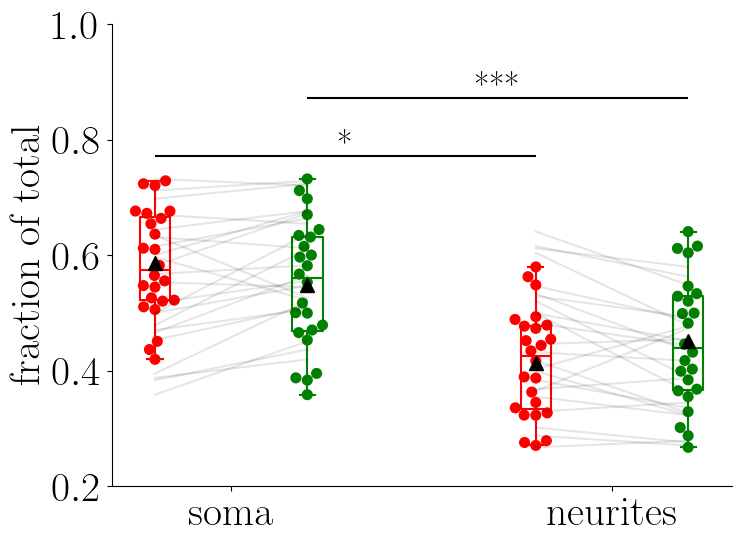

In [54]:
xlab = ""
ylab = r"fraction of total"
title = "FISH quantification in"
SwarmBoxComboSoma(final_fractions,
              x = "compartment",
              y = "fractions",
              fbase="Fig_5f",
              xlabel=xlab,
              ylabel=ylab,
              title=title)#,pairs = [[1,2],[3,4]])

## Fig 5g,h

In [55]:
mRNA_counts = mRNA_counts.reset_index()
mRNA_counts = mRNA_counts.rename(columns={'Unnamed: 0':'Num'})
mRNA_counts[tool] = tool_list[1]
mRNA_counts_c17 = mRNA_counts_c17.reset_index()
mRNA_counts_c17[tool] = tool_list[0]
print("*"*20,"\n",mRNA_counts.head(),"\n","*"*20,"\n","*"*20,"\n",mRNA_counts_c17.head(),"\n","*"*20)
final_counts = pd.concat((mRNA_counts,mRNA_counts_c17))
final_counts.head()


******************** 
    Neuron compartment isoform  Num    Tool
0       1    neurites      E6    6  SpyDen
1       1    neurites      E7   11  SpyDen
2       1        soma      E6  109  SpyDen
3       1        soma      E7  131  SpyDen
4       2    neurites      E6   13  SpyDen 
 ******************** 
 ******************** 
    Neuron compartment isoform  Num        Tool
0       1    neurites      E6    2  StarSearch
1       1    neurites      E7   14  StarSearch
2       1        soma      E6  111  StarSearch
3       1        soma      E7   81  StarSearch
4       2    neurites      E6    5  StarSearch 
 ********************


Neuron compartment isoform  Num    Tool
0       1    neurites      E6    6  SpyDen
1       1    neurites      E7   11  SpyDen
2       1        soma      E6  109  SpyDen
3       1        soma      E7  131  SpyDen
4       2    neurites      E6   13  SpyDen

          1         2    3         4
1  1.000000  0.668214  1.0  0.850825
2  0.668214  1.000000  1.0  1.000000
3  1.000000  1.000000  1.0  1.000000
4  0.850825  1.000000  1.0  1.000000
0.6682138134869836 [1, 2]
ns
1.0 [3, 4]
ns
kk=0
          1         2         3         4
1  1.000000  0.355441  0.061537  1.000000
2  0.355441  1.000000  0.000051  0.011665
3  0.061537  0.000051  1.000000  1.000000
4  1.000000  0.011665  1.000000  1.000000
0.355441187444432 [1, 2]
ns
1.0 [3, 4]
ns
kk=1


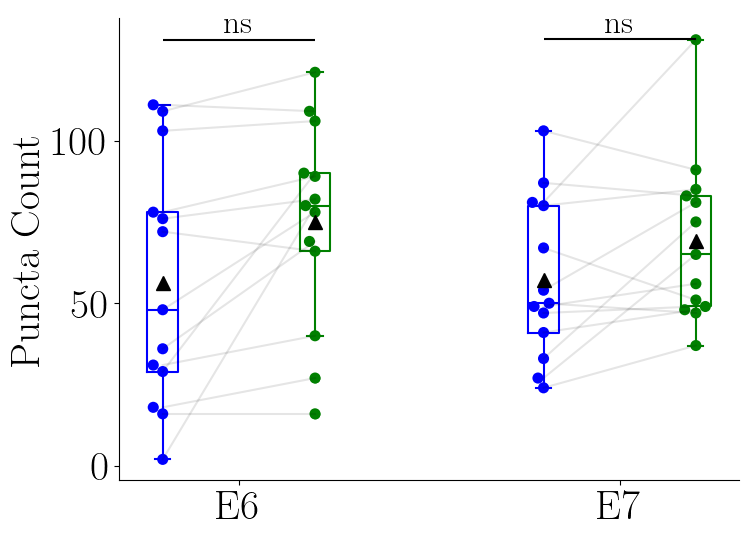

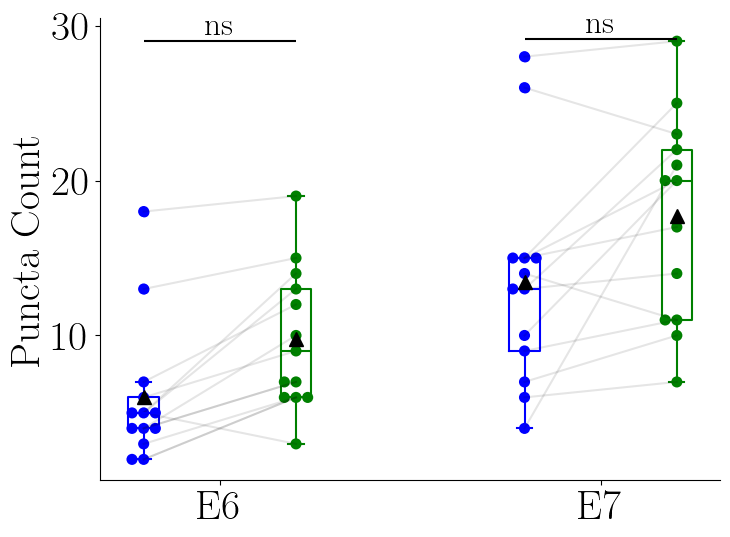

In [56]:

xlab = ""
ylab = "Puncta Count"
title = "Puncta quantification in"
SwarmBoxCombo(final_counts,
              x = "isoform",
              y = "Num",
              fbase="Fig_5GH",
              xlabel=xlab,
              ylabel=ylab,
              title=title,
             frac=False,pairs = [[1,2],[3,4]])


## Fig 5I

******************** 
    cell_id compartment  Num    Tool
0        1    neurites  292  SpyDen
1        1        soma  507  SpyDen
2        2    neurites  246  SpyDen
3        2        soma  422  SpyDen
4        3    neurites  185  SpyDen 
 ******************** 
 ******************** 
    cell_id compartment  Num        Tool
0        1    neurites  484  StarSearch
1        1        soma  538  StarSearch
2        2    neurites  300  StarSearch
3        2        soma  474  StarSearch
4        3    neurites  297  StarSearch 
 ********************


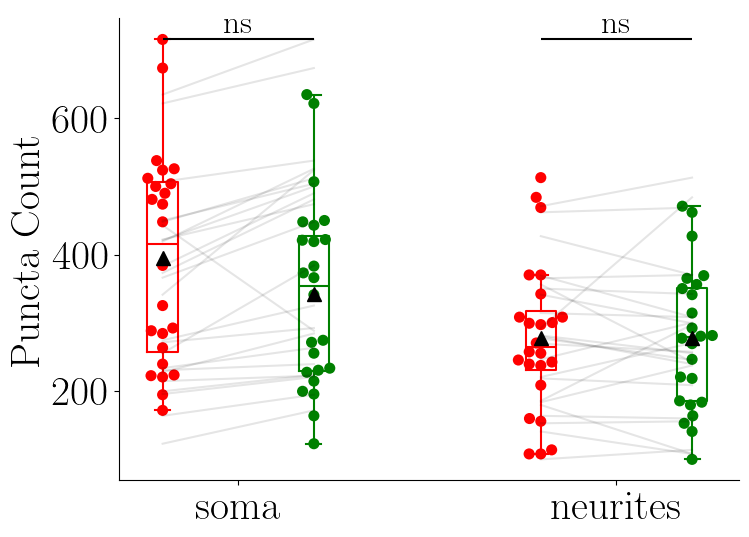

In [57]:
mRNA_counts_SD = mRNA_counts_SD.reset_index()
mRNA_counts_SD = mRNA_counts_SD.rename(columns={'PID':'Num'})
mRNA_counts_SD[tool] = tool_list[1]
mRNA_counts_NB = mRNA_counts_NB.reset_index()
mRNA_counts_NB = mRNA_counts_NB.rename(columns={'PID':'Num'})
mRNA_counts_NB[tool] = tool_list[0]
print("*"*20,"\n",mRNA_counts_SD.head(),"\n","*"*20,"\n","*"*20,"\n",mRNA_counts_NB.head(),"\n","*"*20)
final_counts = pd.concat((mRNA_counts_NB,mRNA_counts_SD))
final_counts.head()

xlab = ""
ylab = "Puncta Count"
title = "Puncta quantification in"
SwarmBoxComboSoma(final_counts,
              x = "compartment",
              y = "Num",
              fbase="Fig_5I",
              xlabel=xlab,
              ylabel=ylab,
              title=title,
             frac=False,pairs = [[1,2],[3,4]])

# Supplemental figure 2

## Fig S2b

In [62]:
Arr = tf.imread('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure2/EgImg.tif')
Dend = np.load('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure2/Dendrite.npy')

(-0.5, 1023.5, 1023.5, -0.5)

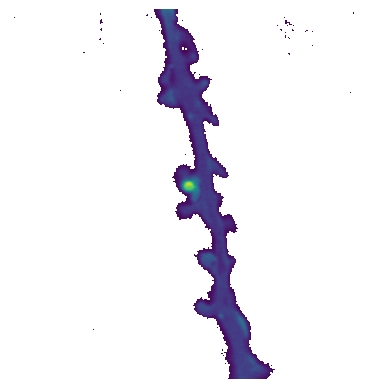

In [63]:
fArr = np.copy(Arr[0])
median = medfilt2d(fArr  , kernel_size=5)
median_thresh = median >= np.mean(median)
fArr[Arr[0]<=np.median(Arr[0])] = math.nan
plt.imshow(fArr)
plt.axis('off')

## Fig S2c

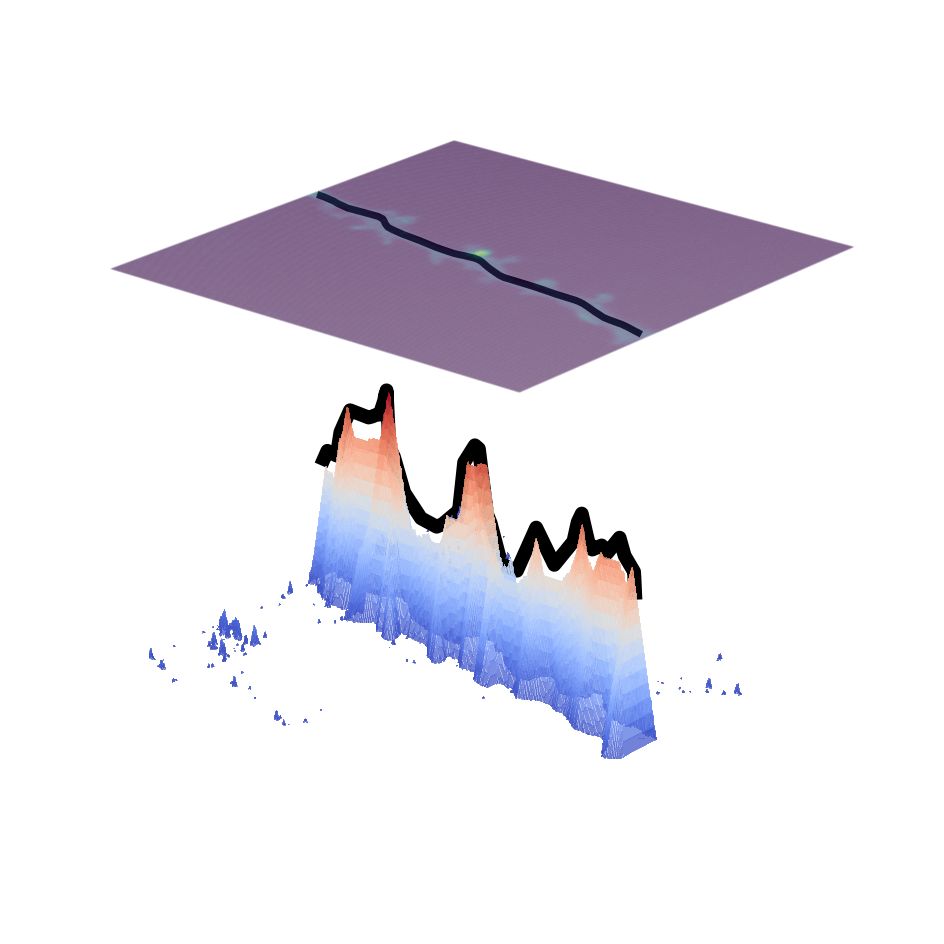

In [64]:
Mask = np.ones((3,3))
median = medfilt2d(Arr[0]  , kernel_size=5)
median_thresh = median >= np.mean(median)

median_thresh = median_thresh.astype(int)
WMat = np.zeros_like(median_thresh)
conv = sp.signal.convolve2d(median_thresh,Mask,'same').astype(int)
while(np.any(conv==9)):
    conv = sp.signal.convolve2d(median_thresh,Mask,'same')
    WMat[conv==9] += 1 
    median_thresh[conv<9] = 0

x = np.linspace(0,1024,1024)
y = np.linspace(0,1024,1024)

X, Y = np.meshgrid(x, y)

WMat2 = sp.signal.convolve2d(WMat,Mask,'same')/9
WMat2[WMat2==0] = math.nan
#### plt.close('all')
scaling_factor = 1  # Adjust this value as needed
X_stretched = X * scaling_factor

scaling_factor = 2  # Adjust this value as needed
Y_stretched = Y * scaling_factor


fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y_stretched, WMat2[:, :], cmap='coolwarm', linewidth=0, antialiased=False, rcount=500, ccount=500, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.axis('off')
ax.plot(Dend[:, 0], Dend[:, 1]*scaling_factor, zs=WMat2[Dend[:, 1], Dend[:, 0]]+5, lw=10, c='k')

img_colormap = plt.get_cmap('viridis')  # Choose a colormap

# Normalize the image to map it to the colormap
img_norm = Normalize()(Arr[0])

# Adjust the alpha value for the surface
alpha_value = 0.1  # You can change this value as needed

# Create a colormap with the desired alpha value
colormap_with_alpha = img_colormap(img_norm)
colormap_with_alpha[:, :, 3] = alpha_value  # Set the alpha channel

# Add the pseudo-color image above the 3D plot with the adjusted colormap
ax.plot_surface(X, Y_stretched, 80 * np.ones_like(X), facecolors=colormap_with_alpha, rcount=500, ccount=500)


ax.plot(Dend[:, 0], Dend[:, 1]*scaling_factor, zs= 80*np.ones_like(len(Dend)), lw=5, c='k')

ax.view_init(elev=22, azim=40, roll=0)


# Supplemental figure 3

In [65]:
img = '/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure1/NN_Example.tif'
tiff_Arr = tf.imread(img)
Dend = np.load('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure1/NN_Eg_Dend.npy')

In [66]:
model = torch.load('/Users/maximilianeggl/SpydenML/SynapseMLModel', map_location=torch.device("cpu"))
model.eval()

len_x = len(tiff_Arr[0, :])
len_y = len(tiff_Arr[ :, 0])
tiff_Arr2 = tiff_Arr.reshape(1, len_y, len_x)

xmin, xmax = max(min(Dend[:, 1]) - 50, 0), min(max(Dend[:, 1]) + 50, tiff_Arr.shape[-2])
ymin, ymax = max(min(Dend[:, 0]) - 50, 0), min(max(Dend[:, 0]) + 50, tiff_Arr.shape[-1])
im = tiff_Arr2[None, 0, int(xmin) : int(xmax), int(ymin) : int(ymax)]
im = np.repeat(im, 3, axis=0)
im = data_transforms["val"](np.moveaxis(im, 0, -1).astype(np.uint8))[None, :, :, :]

testOut = model(im)
sBoxsList = testOut[0]["boxes"].detach().numpy()
sScoreList = testOut[0]["scores"].detach().numpy()

i = 0
tBoxsList = np.copy(sBoxsList)
tScoreList = np.copy(sScoreList)
while i < len(tBoxsList):
    poplist = []
    for j, b in enumerate(tBoxsList):
        if iou(tBoxsList[i], b) > 0 and iou(tBoxsList[i], b) < 1:
            poplist.append(j)
    tBoxsList = np.delete(tBoxsList, poplist, axis=0)
    tScoreList = np.delete(tScoreList, poplist)
    i = i + 1
pPoints = []

score = tScoreList
for b in tBoxsList:
    pPoints.append([(b[0] + b[2]) / 2 + ymin, (b[1] + b[3]) / 2 + xmin])
pPoints = np.array(pPoints)

## Fig S3c

(-0.5, 511.5, 136.5, -0.5)

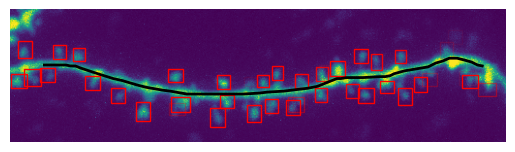

In [67]:
plt.imshow(tiff_Arr[int(xmin) : int(xmax), int(ymin) : int(ymax)])
plt.plot(Dend[:,0]-ymin,Dend[:,1]-xmin,lw=2,c='k')

for b,s in zip(sBoxsList,sScoreList):
    rect =mpatches.Rectangle(b[:2],b[2]-b[0],b[3]-b[1],fill=None,ec='red',alpha=s)
    plt.gca().add_patch(rect)
plt.axis('off')

## Fig S3d

(-0.5, 511.5, 136.5, -0.5)

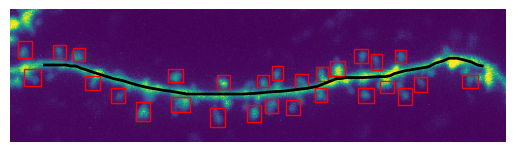

In [68]:
plt.imshow(tiff_Arr[int(xmin) : int(xmax), int(ymin) : int(ymax)])
plt.plot(Dend[:,0]-ymin,Dend[:,1]-xmin,lw=2,c='k')

for b,s in zip(tBoxsList,tScoreList):
    rect =mpatches.Rectangle(b[:2],b[2]-b[0],b[3]-b[1],fill=None,ec='red',alpha=s)
    plt.gca().add_patch(rect)
plt.axis('off')

## Fig S3e

(-0.5, 511.5, 136.5, -0.5)

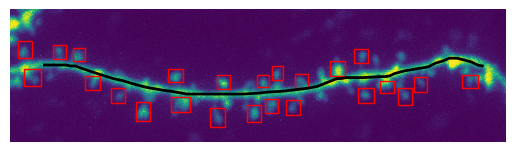

In [69]:
plt.imshow(tiff_Arr[int(xmin) : int(xmax), int(ymin) : int(ymax)])
plt.plot(Dend[:,0]-ymin,Dend[:,1]-xmin,lw=2,c='k')

for b,s in zip(tBoxsList,tScoreList):
    if(s>0.95):
        rect =mpatches.Rectangle(b[:2],b[2]-b[0],b[3]-b[1],fill=None,ec='red',alpha=s)
        plt.gca().add_patch(rect)
plt.axis('off')

## Fig S3f

(-0.5, 511.5, 136.5, -0.5)

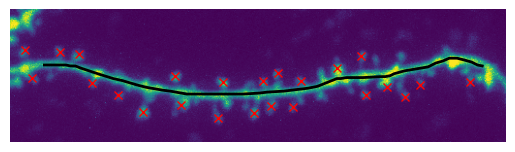

In [70]:
plt.imshow(tiff_Arr[int(xmin) : int(xmax), int(ymin) : int(ymax)])
plt.plot(Dend[:,0]-ymin,Dend[:,1]-xmin,lw=2,c='k')
for p,s in zip(pPoints,tScoreList):
    if(s>0.95):
        plt.plot(p[0]-ymin,p[1]-xmin,'xr')
plt.axis('off')

## Fig S3g

(-0.5, 1023.5, 1023.5, -0.5)

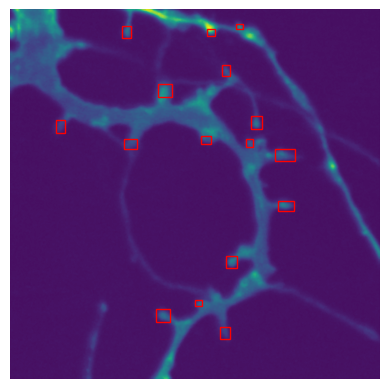

In [71]:
Dir ="/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure1/"
I = imageio.imread(Dir+'Helm.png')
B = np.load(Dir+'Helm_BBS.npy')

plt.imshow(I)
for b in B:
    plt.gca().add_patch(mpatches.Rectangle(b[:2],b[2]-b[0],b[3]-b[1],
                                      fill=None,ec='red'))
plt.axis('off')

## Fig S3h

(-0.5, 127.5, 127.5, -0.5)

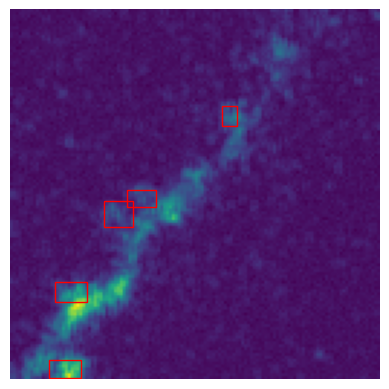

In [72]:

I = imageio.imread(Dir+'D3.png')
B = np.load(Dir+'D3_BBS.npy')

plt.imshow(I)
for b in B:
    plt.gca().add_patch(mpatches.Rectangle(b[:2],b[2]-b[0],b[3]-b[1],
                                      fill=None,ec='red'))
plt.axis('off')

## Fig S3i

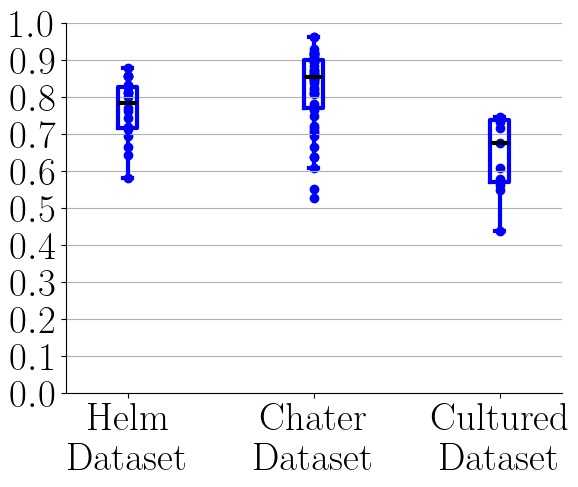

In [73]:
RawPC  = [0.659090909090909	,0.725	,0.619047619047619	,0.666666666666667	,0.67741935483871	,0.736842105263158	,0.733333333333333	,0.647058823529412	,0.411764705882353	,0.552631578947368	,0.659090909090909]		
RawRC  = [0.852941176470588	,0.763157894736842	,0.541666666666667	,0.466666666666667	,0.552631578947368	,0.756756756756757	,0.733333333333333	,0.5	,0.466666666666667	,0.875	,0.783783783783784]
RawF1C = [0.743589743589744	,0.743589743589744	,0.577777777777778	,0.549019607843137	,0.608695652173913	,0.746666666666667	,0.733333333333333	,0.564102564102564	,0.4375	,0.67741935483871	,0.716049382716049]

RawF1G =  np.array([0.875     , 0.7826087 , 0.92      , 0.90196078, 0.76595745,
        0.71641791, 0.8125    , 0.75      , 0.86567164, 0.88372093,
        0.875     , 0.96296296, 0.86153846, 0.82608696, 0.92307692,
        0.80769231, 0.84745763, 0.85714286, 0.96428571, 0.83870968,
        0.91666667, 0.89473684, 0.86363636, 0.91666667, 0.7037037 ,
        0.9       , 0.9       , 0.9047619 , 0.86792453, 0.89473684,
        0.70833333, 0.85185185, 0.63768116,        0.66666667, 0.63829787, 0.55172414, 0.72131148, 0.60869565,
        0.52631579,  0.90909091, 0.85714286, 0.81081081,
        0.90322581, 0.85106383, 0.84444444, 0.91428571, 0.69565217,
        0.93023256, 0.85      , 0.82051282])

RawF1H = np.array([0.85714286, 0.74418605, 0.69565217, 0.71428571, 0.81081081,
        0.64516129, 0.88      , 0.77192982, 0.58064516, 0.81355932,
        0.83333333, 0.72      , 0.66666667, 0.85714286, 0.85714286,
        0.8       , 0.81081081, 0.76363636, 0.71698113, 0.82758621])

bp1 = plt.boxplot(RawF1H,positions=[0.5],boxprops=dict(linewidth=3, color=c,),
            capprops=dict(linewidth=3,color=
                          c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(RawF1H)*0.5,RawF1H,c=c)



plt.boxplot(RawF1G,positions=[2],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(RawF1G)*2,RawF1G,c=c)



plt.boxplot(RawF1C,positions=[3.5],boxprops=dict(linewidth=3, color=c),
            capprops=dict(linewidth=3,color=c),
            whiskerprops=dict(linewidth=3,color=c),
            flierprops=dict(linewidth=3,color=c, markeredgecolor=c),
            medianprops=dict(linewidth=3,color='k'),showfliers=False)
plt.scatter(np.ones_like(RawF1C)*3.5,RawF1C,c=c)




ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.xticks([0.5,2,3.5],['Helm  \n Dataset','Chater \n Dataset','Cultured \n Dataset'])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.ylim([0,1])
plt.grid(axis = 'y')
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Figures/RawNNF1.pdf',format='pdf',bbox_inches='tight')

# Supplemental figure 5

(-0.5, 1023.5, 1023.5, -0.5)

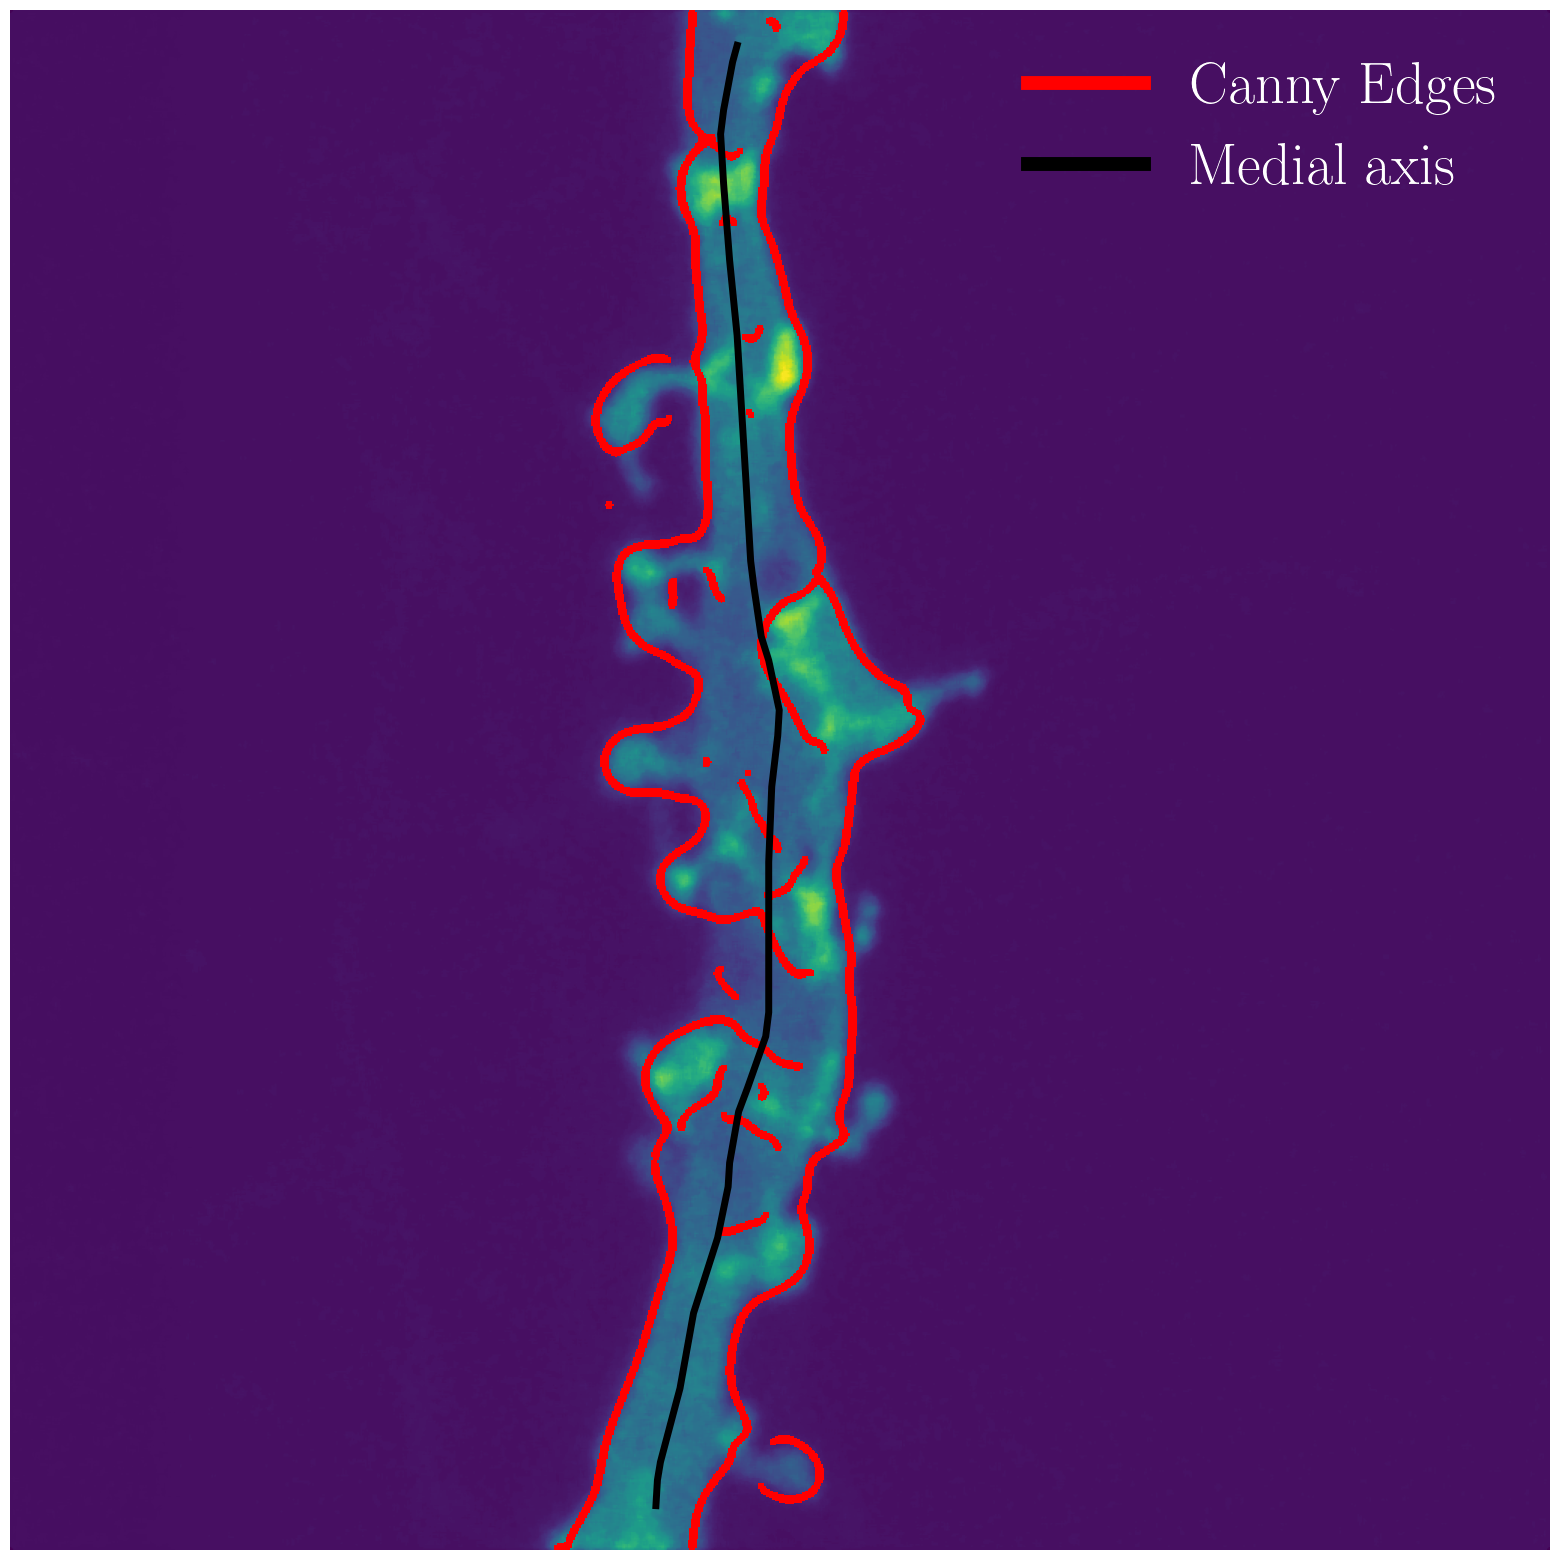

In [74]:

Dir ='/Users/maximilianeggl/Dropbox/PostDoc/ToolFigs/Data/FigureDat/SFigure4/'
Arr = tf.imread(Dir+'EgImg.tif')
Dend = np.load(Dir+'Dendrite.npy')
fArr = np.copy(Arr[0])
median = medfilt2d(fArr  , kernel_size=5)
median_thresh = median >= np.mean(median)
fArr[Arr[0]<=np.median(Arr[0])] = math.nan

# Apply Canny edge detection
ca = canny(median, sigma=18)

# Apply dilation to thicken the edges
selem = sk.morphology.disk(3)  # Adjust the disk size for thicker edges
ca_thick = sk.morphology.dilation(ca, selem)
ca3 = np.copy(ca_thick).astype(np.float64)
ca3[ca3==0] = math.nan

# Create a figure and axes
fig, ax = plt.subplots(figsize=(20, 20))

# Display the original image
plt.imshow(median)

cmap_red = LinearSegmentedColormap.from_list("custom_red", ["red", "red"])


# Overlay the thicken Canny edges with reduced transparency
plt.imshow(ca3, cmap=cmap_red)  # Adjust alpha to control transparency

ca_legend = plt.Line2D([0], [0], color='red', label='Canny Edges')
ax.add_artist(ca_legend)

den_legend = plt.Line2D([0], [0], color='k', label='Medial axis')
ax.add_artist(den_legend)

# Create a legend
leg = ax.legend(handles=[ca_legend,den_legend],fontsize=42,frameon=False)

for text in leg.get_texts():
    text.set_color("white")

for line in leg.get_lines():
    line.set_linewidth(10.0)
    
plt.plot(Dend[:, 0], Dend[:, 1],lw=5,c='k')
ax.axis('off')


# Supplemental figure 6

## Fig S6A

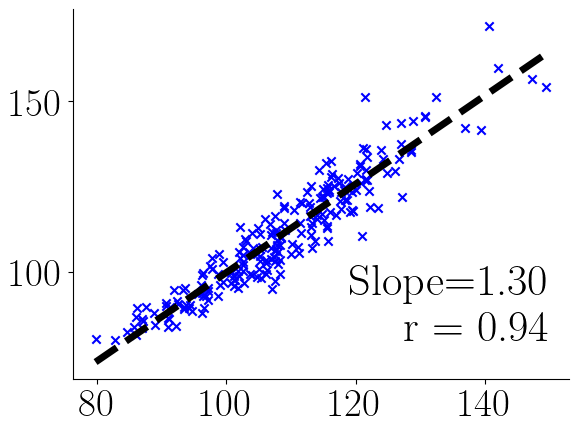

In [75]:
plt.scatter(Im1,Im2,c='b',marker='x',label='Goda dataset')
plt.plot(np.arange(min(Im1),max(Im1),1),fg(np.arange(min(Im1),max(Im1),1)),lw=5,c='k',ls='--')
plt.text(150,80,'Slope=1.30 \n r = 0.94',fontsize=32,horizontalalignment='right',)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)


## Fig S6B

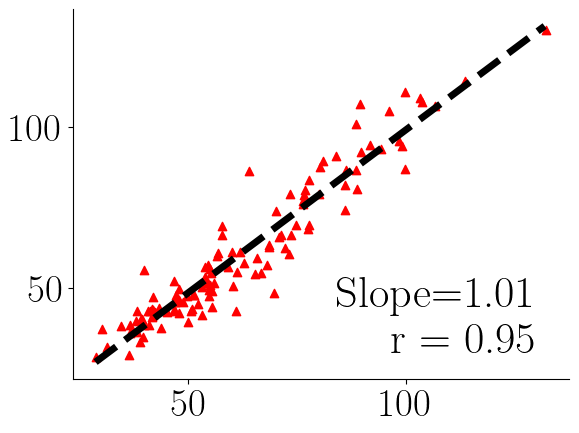

In [76]:
plt.scatter(hIm1,hIm2,c='r',marker='^',label='Goda dataset')
plt.plot(np.arange(min(hIm1),max(hIm1),1),fh(np.arange(min(hIm1),max(hIm1),1)),lw=5,c='k',ls='--')
plt.text(130,30,'Slope=1.01 \n r = 0.95',fontsize=32,horizontalalignment='right',)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

## Fig S6C

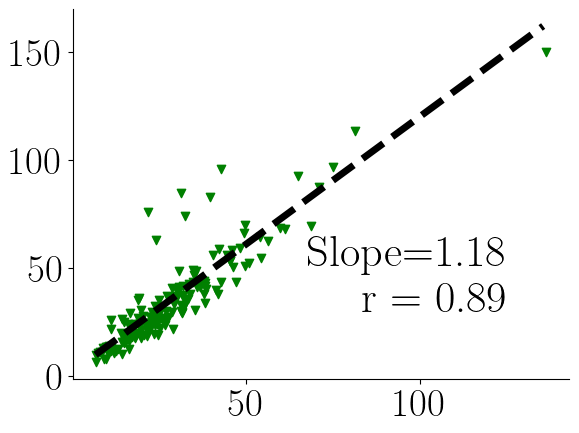

In [77]:
plt.scatter(cIm1,cIm2,c='g',marker='v',label='Cultured dataset')
plt.plot(np.arange(min(cIm1),max(cIm1),1),fc(np.arange(min(cIm1),max(cIm1),1)),lw=5,c='k',ls='--')
plt.text(125,30,'Slope=1.18 \n r = 0.89',fontsize=32,horizontalalignment='right',)

plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

# Supplemental figure 7

## Fig S7a,b

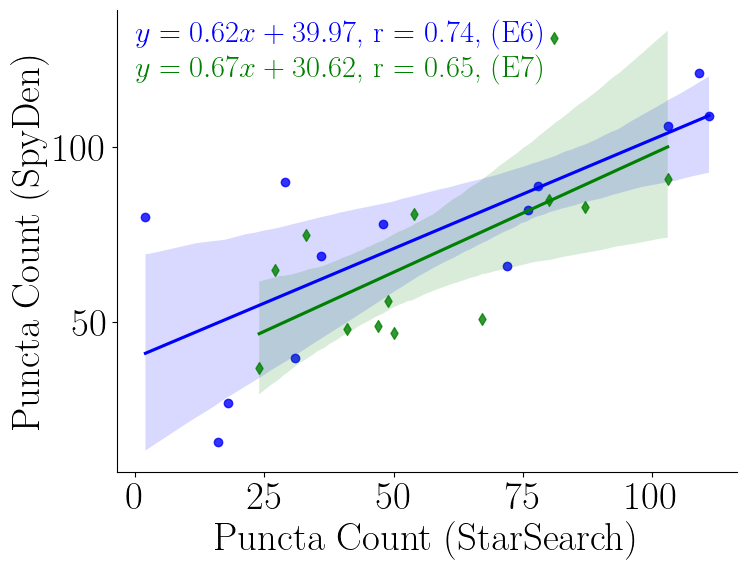

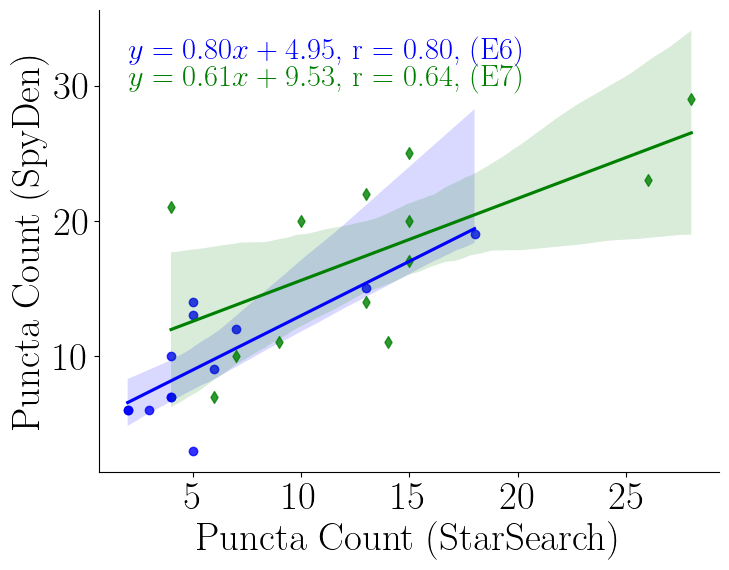

In [78]:
f_count_rp = mRNA_counts
f_count_rp["Num_ss"] = mRNA_counts_c17["Num"]
f_count_rp.head(),f_count_rp.shape

mRNA_counts = mRNA_counts.rename(columns={'Unnamed: 0':'Num'})
mRNA_counts[tool] = tool_list[1]
mRNA_counts_c17[tool] = tool_list[0]

final_counts = pd.concat((mRNA_counts,mRNA_counts_c17))
final_counts.head()
stat = np.zeros((4,5)) # slope,intecept, r_val,p_val,std_err
i = 0
my_pal = ['b','g']
marks = ['o','d']
panel=["A","B"]
for j ,comp in enumerate(compartments): 
    fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
    xfsize = 18
    for k,iso in enumerate(isoforms):
        data_to_regress = final_counts[(final_counts["compartment"]==comp) & (final_counts["isoform"]==iso)]
        comp_data = np.array(data_to_regress.groupby(["Tool"]).Num.apply(list).tolist())
        stat[i] = stats.linregress(comp_data[1],comp_data[0])
        data_to_plot = f_count_rp[(f_count_rp["compartment"]==comp) & (f_count_rp["isoform"] == iso)]
        sns.regplot(data=data_to_plot,
                   x="Num_ss",
                   y="Num",
                   marker=marks[k],
                   color = my_pal[k],
                   ax=ax,
                   )
        ax.set_xlabel("Puncta Count (StarSearch)",fontsize=28)
        ax.set_ylabel("Puncta Count (SpyDen)",fontsize=28)
        ax.tick_params(axis='both', which='major', labelsize=28)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(axis='both', which='minor', labelsize=28)
        txt = r"$y={:.2f}x+{:10.2f}$, r = {:.2f}, ({})".format(stat[i][0],stat[i][1],stat[i][2],iso)
        x_pos = [0,2]
        y_pos = [[130,120],[32,30]]
        ax.text(x=x_pos[j],y=y_pos[j][k],s = txt,fontsize=22,color=my_pal[k])
        i += 1
        if(j==1):
            ax.set_xticks([5,10,15,20,25])

## Fig S7c

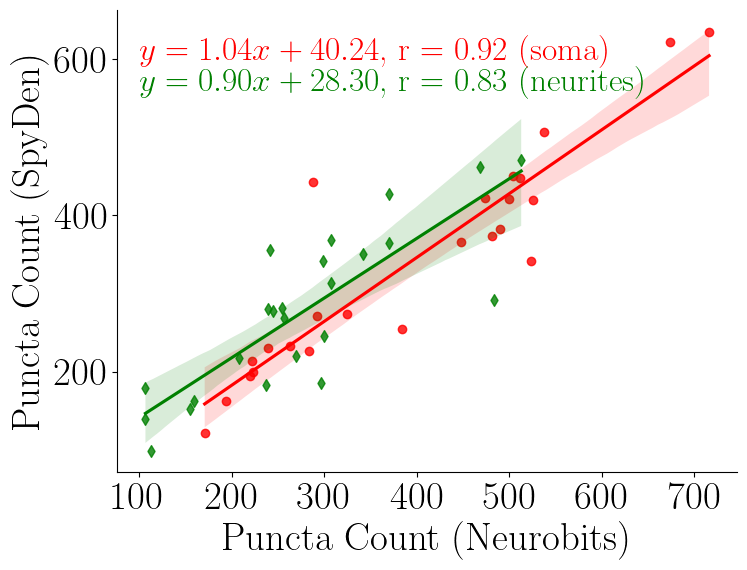

In [79]:
mRNA_counts_SD = mRNA_counts_SD.rename(columns={'PID':'Num'})
mRNA_counts_SD[tool] = tool_list[1]

mRNA_counts_NB = mRNA_counts_NB.rename(columns={'PID':'Num'})
mRNA_counts_NB[tool] = tool_list[0]

final_counts = pd.concat((mRNA_counts_NB,mRNA_counts_SD))
final_counts.head()

f_count_rp = mRNA_counts_SD
f_count_rp["Num_NB"] = mRNA_counts_NB["Num"]
fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
ax = [ax,ax]
xfsize = 28

stat = np.zeros((2,5)) # slope,intecept, r_val,p_val,std_err

i = 0
my_pal = ['r','g']
marks = ['o','d']
for comp in compartments:

    data_to_regress= final_counts[final_counts["compartment"]==comp]
    comp_data = np.array(data_to_regress.groupby(["Tool"]).Num.apply(list).tolist())#.to_numpy()
    stat[i] = stats.linregress(comp_data[0,:],comp_data[1,:])
    data_to_plot = f_count_rp[f_count_rp["compartment"]==comp]
    sns.regplot(data=data_to_plot,
               x="Num_NB",
               y="Num",
               color = my_pal[i],
               marker=marks[i],
               ax=ax[i],
              )
    ax[i].set_xlabel("Puncta Count (Neurobits)",fontsize=xfsize)
    ax[i].set_ylabel("Puncta Count (SpyDen)",fontsize=xfsize)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].tick_params(axis='both', which='major', labelsize=xfsize)
    ax[i].tick_params(axis='both', which='minor', labelsize=xfsize)
    ax[i].set_xticks([100,200,300,400,500,600,700])
    txt = r"$y={:.2f}x+{:10.2f}$, r = {:.2f} ({})".format(stat[i][0],stat[i][1],stat[i][2],comp)
    y_pos = [600,570]
    ax[i].text(x=100,y=y_pos[i]-i*10,s = txt,fontsize=24,color=my_pal[i])
    i += 1